# Creating data directory and importing packages

How to load the data in:

1) Go to kaggle.com

2) Go to account settings --> under API click "create new token". This will download a file called kaggle.json.

3) In the little folder on the left titled "Files", click the "Upload to session storage" icon on the top. Upload kaggle.json. Don't move it anywhere, the path below depends on that.

4) THEN run the two code blocks below.

This should allow the dataset to be loaded in automatically after. The dataset is very, very large, and it is difficult to load it into the file otherwise.

In [ ]:
import os
import shutil

kaggle_json_path = "/content/kaggle.json"  # Adjust this if it's in a different location
target_path = os.path.expanduser("~/.kaggle/kaggle.json")

os.makedirs(os.path.dirname(target_path), exist_ok=True)
shutil.move(kaggle_json_path, target_path)

os.chmod(target_path, 0o600)  # Set permissions for security


In [ ]:
# Install packages if needed with this command:
# !pip install -r requirements.txt
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# 1. Load dataset


**Note**: No code in this section has been edited in anyway.

In [ ]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset',
                                    path=data_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/zeyad1mashhour/driver-inattention-detection-dataset


In [ ]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f:
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f:
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]),
                                label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f:
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]),
                               label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f:
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]),
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


# Pre-processing, Training Baseline and Visualizing:

#### 1) Convert the target values using the proper function for one hot encoding.

In [ ]:
# Initilize the OneHotEncoder (aka the "correct function")
encoder = OneHotEncoder(sparse_output = False) # ensures output is a dense array, not a sparse matrix

# Fit and transform encoder on the 'label' columns of the train, val and test data frames into one-hot encoded format
train_labels = encoder.fit_transform(df_train[['label']])
val_labels = encoder.fit_transform(df_val[['label']])
test_labels = encoder.fit_transform(df_test[['label']])

# Concatenates original 'img' column with the encoded labels, for each set
# Creates a new data frames with the image data and labels
df_train_encoded = pd.concat([df_train[['img']], pd.DataFrame(train_labels, columns=encoder.categories_[0])], axis=1)
df_val_encoded = pd.concat([df_val[['img']], pd.DataFrame(val_labels, columns=encoder.categories_[0])], axis=1)
df_test_encoded = pd.concat([df_test[['img']], pd.DataFrame(test_labels, columns=encoder.categories_[0])], axis=1)

In [ ]:
# Visualizing encoded data:
print(df_train_encoded.head())

                                                 img  DangerousDriving  \
0  driver-inattention-detection-dataset/train/gB_...               0.0   
1  driver-inattention-detection-dataset/train/gA_...               0.0   
2  driver-inattention-detection-dataset/train/gA_...               0.0   
3  driver-inattention-detection-dataset/train/gA_...               1.0   
4  driver-inattention-detection-dataset/train/gB_...               0.0   

   Distracted  Drinking  SafeDriving  SleepyDriving  Yawn  
0         0.0       0.0          1.0            0.0   0.0  
1         0.0       0.0          1.0            0.0   0.0  
2         0.0       1.0          0.0            0.0   0.0  
3         0.0       0.0          0.0            0.0   0.0  
4         0.0       0.0          1.0            0.0   0.0  


#### 2) Display of 15 randomly selected samples from the dataset.

                                                     img  DangerousDriving  \
3238   driver-inattention-detection-dataset/train/gB_...               0.0   
11208  driver-inattention-detection-dataset/train/gB_...               0.0   
3753   driver-inattention-detection-dataset/train/gB_...               0.0   
357    driver-inattention-detection-dataset/train/gB_...               0.0   
6835   driver-inattention-detection-dataset/train/gB_...               0.0   
11512  driver-inattention-detection-dataset/train/gA_...               0.0   
2325   driver-inattention-detection-dataset/train/gB_...               1.0   
8991   driver-inattention-detection-dataset/train/gB_...               0.0   
10754  driver-inattention-detection-dataset/train/gA_...               0.0   
9226   driver-inattention-detection-dataset/train/gB_...               1.0   
1683   driver-inattention-detection-dataset/train/gB_...               1.0   
10947  driver-inattention-detection-dataset/train/gB_...        

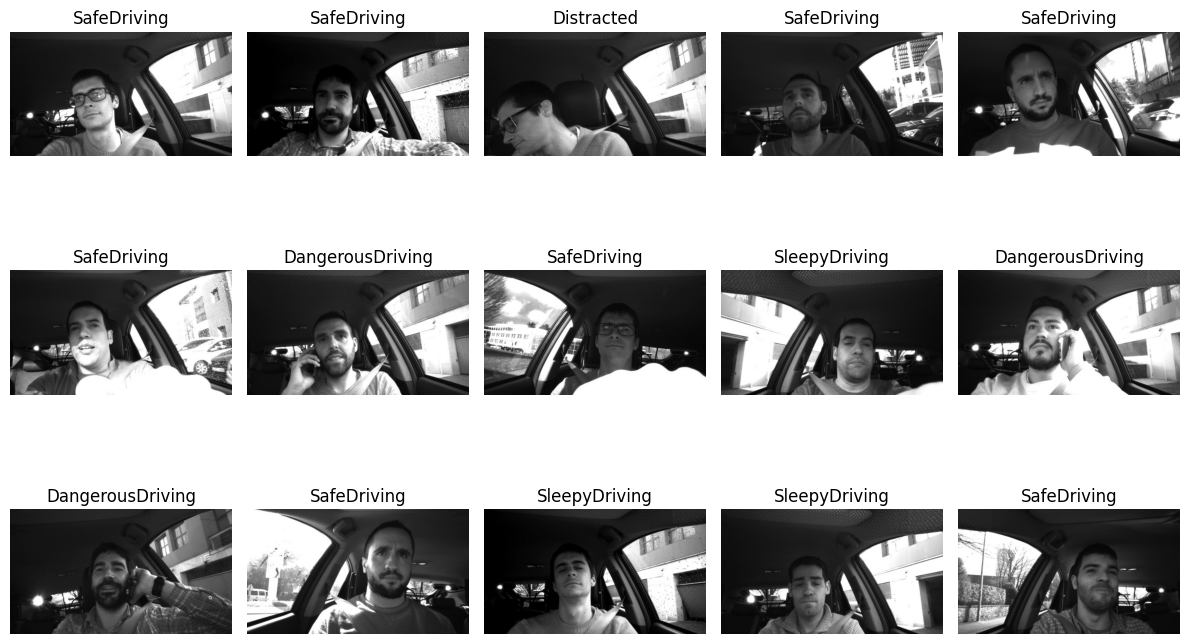

In [ ]:
# Randomly choosing 15 samples

from random import sample

samples = df_train_encoded.sample(15, random_state = 42) # select 15 samples. fixed using a seed
print(samples) # samples are visualized below

# Displaying images
# Set up the figure
plt.figure(figsize=(12, 8))

# Loop through each sampled image
for i, row in enumerate(samples.itertuples()):
    img_path = row.img
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Warning: Image not found at {img_path}")
        continue

    # Get the label for the current image
    label = df_train_encoded[df_train_encoded['img'] == img_path].drop(columns=['img']).idxmax(axis=1).iloc[0]

    plt.subplot(3, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(label)  # Set the title to the label

plt.tight_layout()
plt.show()


##### Bar plot to visualize the class label distribution of the dataset.

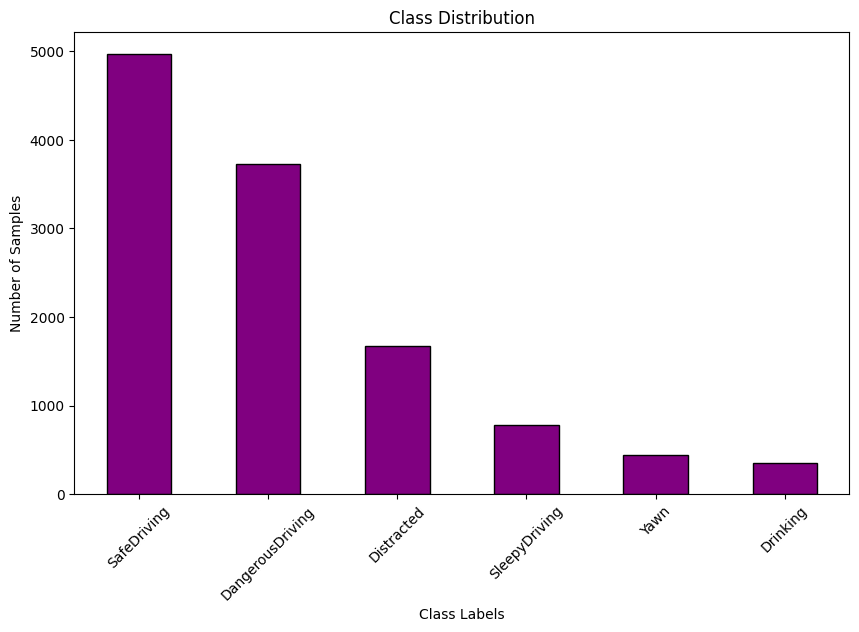

In [ ]:
import matplotlib.pyplot as plt

sampled_df = df_train.sample(11948, random_state=42)
class_counts = sampled_df["label"].value_counts() # counting occurrances of each unique class

# set size of figure and colors
plt.figure(figsize=(10, 6))
class_counts.plot(kind="bar", color="purple", edgecolor="black")

# these set the names for the plot and rotate the bar names to beter fit
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(rotation=45)

plt.show()

In [ ]:
print(df_train_encoded.shape)
df_train_encoded.head()

(11948, 7)


,img,DangerousDriving,Distracted,Drinking,SafeDriving,SleepyDriving,Yawn
0,driver-inattention-detection-dataset/train/gB_...,0.0,0.0,0.0,1.0,0.0,0.0
1,driver-inattention-detection-dataset/train/gA_...,0.0,0.0,0.0,1.0,0.0,0.0
2,driver-inattention-detection-dataset/train/gA_...,0.0,0.0,1.0,0.0,0.0,0.0
3,driver-inattention-detection-dataset/train/gA_...,1.0,0.0,0.0,0.0,0.0,0.0
4,driver-inattention-detection-dataset/train/gB_...,0.0,0.0,0.0,1.0,0.0,0.0


#### 4) Implementing the baseline model

In [ ]:
from keras import models, layers, Input

def build_model():
  model_baseline = models.Sequential() # initialize

  # FIRST CONVOLUTIONAL BLOCK:
  # 2d convolutional layer, 8 filters, input_shape appropriate for grey-scale images
  model_baseline.add(layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (img_height, img_width, 1)))
  # max pooling layer to reduce spatial dimensions
  model_baseline.add(layers.MaxPooling2D((2,2)))

  # SECOND CONVOVLUTIONAL BLOCK:
  # Same specifications and another max pooling
  model_baseline.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model_baseline.add(layers.MaxPooling2D((2,2)))

  # THIRD CONVOVLUTIONAL BLOCK:
  # Same specifications and another max pooling
  model_baseline.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model_baseline.add(layers.MaxPooling2D((2,2)))

  # FULLY CONNECTED LAYERS:
  # Flatten into a 1D vector
  model_baseline.add(layers.Flatten())
  # Dense fully connected layer, projects the flattened features into a 10D space
  model_baseline.add(layers.Dense(10, activation = 'relu'))
  # Final dense layer, with 6 units (one per class)
  model_baseline.add(layers.Dense(6, activation = 'softmax')) # softmax converts logits into probabilities, for multi-class classification

  # MODEL COMPILATION:
  # categorical cross entropy is appropriate for multi-class classification
  model_baseline.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model_baseline

model_baseline = build_model()
model_baseline.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

Training the baseline model on the entire dataset

In [ ]:
history1 = model_baseline.fit(train_data, validation_data = val_data, epochs = 10, verbose = 1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 92s 242ms/step - accuracy: 0.4573 - loss: 1.4216 - val_accuracy: 0.6119 - val_loss: 1.0807
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 136s 227ms/step - accuracy: 0.6215 - loss: 1.0096 - val_accuracy: 0.7237 - val_loss: 0.8150
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 87s 233ms/step - accuracy: 0.6937 - loss: 0.8168 - val_accuracy: 0.7294 - val_loss: 0.7344
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 146s 245ms/step - accuracy: 0.7347 - loss: 0.7262 - val_accuracy: 0.7492 - val_loss: 0.6924
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 89s 238ms/step - accuracy: 0.7572 - loss: 0.6579 - val_accuracy: 0.7445 - val_loss: 0.6942
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 86s 230ms/step - accuracy: 0.7651 - loss: 0.6324 - val_accuracy: 0.7836 - val_loss: 0.5949
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.7722 - loss: 0.5975 - val_accuracy: 0.7742 - val_loss: 0.6197
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 70s 186ms/step - accuracy: 0.7833 - loss: 0.5706 - v

In [ ]:
test_loss, test_accuracy = model_baseline.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.7916 - loss: 0.5894
Test Loss: 0.6046
Test Accuracy: 0.7888


#### 5) Analyze the performance of the baseline

##### (i) the training and validation losses and accuracies on the training and validation set through epochs

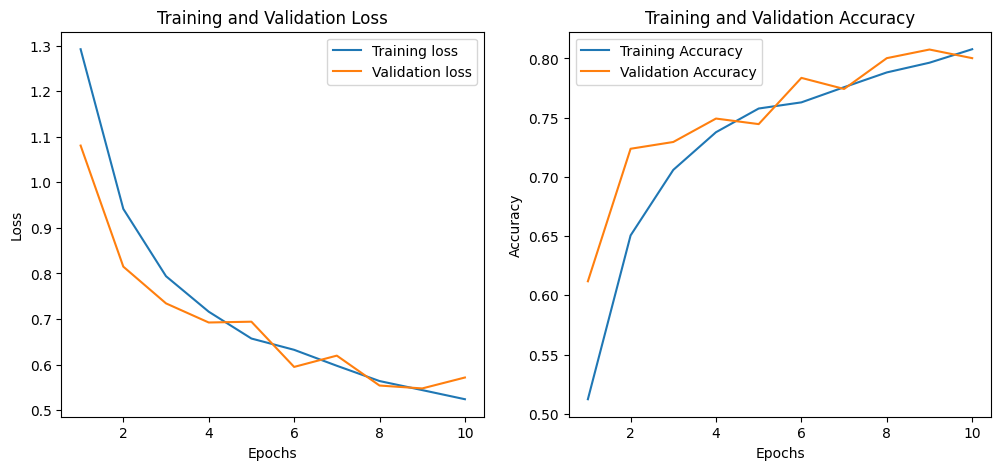

In [ ]:
# Extracting training history:

train_loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
train_acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
epochs = range(1, len(train_loss) + 1)

# Plotting:

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label = "Training loss") # plots the training data line according to its the loss, Echochs are all the times the entire model runs through all the data by means of batches, we used 10 epochs earlier
plt.plot(epochs, val_loss, label = "Validation loss") # plots the validation data line according to its the loss
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy") # plots the training data line according to its the accuracy
plt.plot(epochs, val_acc, label="Validation Accuracy") # plots the validation data line according to its the accuracy
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.show()

# shown: best epoch = 10

##### (ii) the Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step


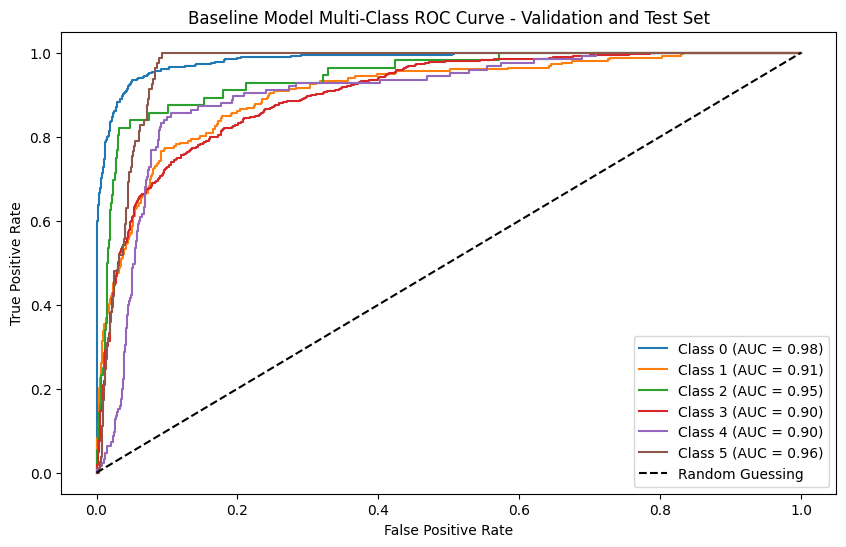

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Ensure labels are one-hot encoded
label_binarizer = LabelBinarizer().fit(df_train_encoded.iloc[:, 1:].columns)

# Convert labels to one-hot encoding format
y_val_onehot = label_binarizer.transform(df_val_encoded.iloc[:, 1:].idxmax(axis=1))
y_test_onehot = label_binarizer.transform(df_test_encoded.iloc[:, 1:].idxmax(axis=1))

# Get model predictions
y_val_pred = model_baseline.predict(val_data)
y_test_pred = model_baseline.predict(test_data)

# Plot ROC Curve
plt.figure(figsize=(10, 6))

for i in range(y_val_onehot.shape[1]):  # Loop through each class
    fpr, tpr, _ = roc_curve(y_val_onehot[:, i], y_val_pred[:, i]) # same as the codeblock above
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing") # the dotted line shows what the predictions would be if the model was just randomly guessing instead of learning from the data
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Baseline Model Multi-Class ROC Curve - Validation and Test Set")
plt.legend()
plt.show()


##### (iii) Report performance measures (accuracy, precision, recall, and F1-score) for both validation and test sets.

In [ ]:
# Reporting metrics!

from sklearn.metrics import classification_report

# Get predictions on validation set
val_preds = model_baseline.predict(val_data)
val_preds_classes = val_preds.argmax(axis=1) # Convert to class labels
val_true_classes = val_data.classes  # Get true labels

# Get predictions on test set
test_preds = model_baseline.predict(test_data)
test_preds_classes = test_preds.argmax(axis=1)
test_true_classes = test_data.classes

# Compute performance metrics, classification report gives an overview of all of the evaluation metrics. It compares the true classes to models predictions
print("Validation Performance:")
print(classification_report(val_true_classes, val_preds_classes))

print("Test Performance:")
print(classification_report(test_true_classes, test_preds_classes))


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step
Validation Performance:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       609
           1       0.45      0.81      0.58       252
           2       0.38      0.79      0.51        56
           3       0.86      0.58      0.70       799
           4       0.36      0.69      0.47       125
           5       0.31      0.14      0.19        81

    accuracy                           0.69      1922
   macro avg       0.55      0.64      0.56      1922
weighted avg       0.77      0.69      0.70      1922

Test Performance:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       301
           1       0.51      0.78      0.61       152
           2       0.31      0.64      0.42        25
           3       0.85      0.57      0.68       412
           4       0.40      0.78      0.53        69
         

##### (iv) Confusion matrix for the validation and test sets

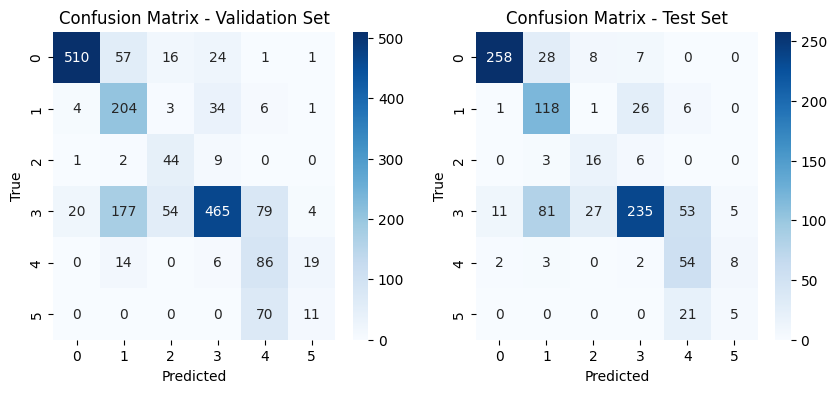

In [ ]:
# CONFUSION MATRIX

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
val_cm = confusion_matrix(val_true_classes, val_preds_classes)
test_cm = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix for validation set
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")

# Plot confusion matrix for test set
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")

plt.show()

# Oversampling the training data

**Analysis**:

Far fewer misclassifications for the underrepresented classes. Yawning and drinking show improvement, but dangerous driving still getting confused with distracted driving (although an improvement :))

From analyzing the class distribution we observed major class imbalance in the dataset and decided to try applying oversampling to the training data

In [ ]:
# OVERSAMPLING

from imblearn.over_sampling import RandomOverSampler

# Extract images and categorical labels (convert from one-hot encoding)
X_train = df_train_encoded[['img']]
y_train = df_train_encoded.drop(columns=['img']).idxmax(axis=1)  # Convert one-hot back to categorical

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert back to DataFrame
df_train_balanced = pd.DataFrame({'img': X_resampled['img'], 'label': y_resampled})

print(df_train_balanced['label'].value_counts())  # Check new class distribution


label
SafeDriving         4969
Drinking            4969
DangerousDriving    4969
Distracted          4969
SleepyDriving       4969
Yawn                4969
Name: count, dtype: int64


In [ ]:
train_data_balanced = data_gen.flow_from_dataframe(
    df_train_balanced, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)


Found 29814 validated image filenames belonging to 6 classes.


We then fit the baseline model using the oversampled training data

In [ ]:
model_baseline_balanced = build_model()
history2 = model_baseline_balanced.fit(train_data_balanced, validation_data = val_data, epochs = 10, verbose = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 198s 211ms/step - accuracy: 0.3949 - loss: 1.4221 - val_accuracy: 0.6165 - val_loss: 0.9663
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 182s 195ms/step - accuracy: 0.6915 - loss: 0.7867 - val_accuracy: 0.6946 - val_loss: 0.7807
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 202s 217ms/step - accuracy: 0.7654 - loss: 0.6177 - val_accuracy: 0.7341 - val_loss: 0.7014
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 186s 199ms/step - accuracy: 0.8041 - loss: 0.5161 - val_accuracy: 0.7726 - val_loss: 0.6098
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 165s 177ms/step - accuracy: 0.8290 - loss: 0.4458 - val_accuracy: 0.8007 - val_loss: 0.5655
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 204s 179ms/step - accuracy: 0.8522 - loss: 0.3968 - val_accuracy: 0.7820 - val_loss: 0.5795
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 162s 174ms/step - accuracy: 0.8626 - loss: 0.3752 - val_accuracy: 0.8267 - val_loss: 0.5072
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 167s 179ms/step - accuracy: 0.8757 -

**Analysis:**

Overfitting is happening!

Training loss decreases, but validation loss fluctuates a lot after about 10 epochs

Training accuracy stabilizes at 91%, which is much higher than validation accuracy at 85%

Fix: use early stopping by preventing the model from fitting too far!

In [ ]:
from sklearn.metrics import classification_report

# Get predictions on validation set
val_preds = model_baseline_balanced.predict(val_data)
val_preds_classes = val_preds.argmax(axis=1)  # Convert softmax probabilities to class labels
val_true_classes = val_data.classes  # Get true labels

# Get predictions on test set
test_preds = model_baseline_balanced.predict(test_data)
test_preds_classes = test_preds.argmax(axis=1)
test_true_classes = test_data.classes

# Compute classification reports
print("Validation Performance of the oversampled data model:")
print(classification_report(val_true_classes, val_preds_classes))

print("Test Performance of the oversampled data model:")
print(classification_report(test_true_classes, test_preds_classes))


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
🚀 Validation Performance:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       609
           1       0.65      0.76      0.70       252
           2       0.73      0.80      0.76        56
           3       0.88      0.83      0.85       799
           4       0.84      0.74      0.79       125
           5       0.92      0.96      0.94        81

    accuracy                           0.86      1922
   macro avg       0.83      0.84      0.83      1922
weighted avg       0.86      0.86      0.86      1922

🚀 Test Performance:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       301
           1       0.75      0.82      0.78       152
           2       0.66      0.76      0.70        25
           3       0.88      0.81      0.84       412
           4       0.73      0.77      0.75        69
     

**Analysis**

Overall accuracy has improved (yay!)

Oversampling has helped rare classes like drinking and yawning. Only class 3 (distracted) dropped, but accuracy is still high. Yawning has seen a massive improvement: 43 - 96! Model is no longer ignoring the minority classes :)

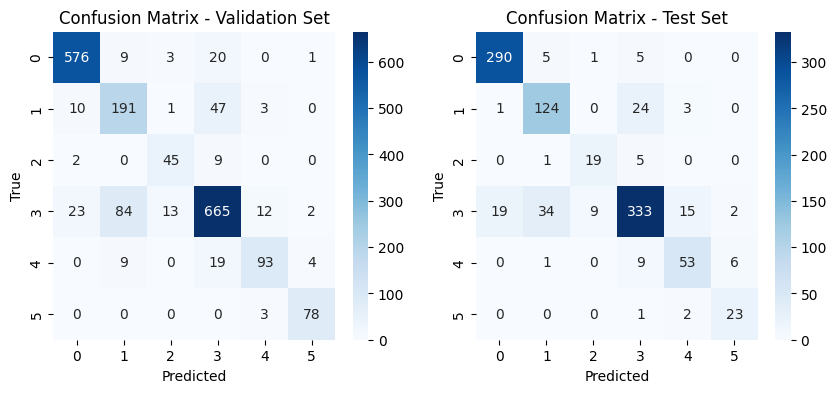

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
val_cm = confusion_matrix(val_true_classes, val_preds_classes)
test_cm = confusion_matrix(test_true_classes, test_preds_classes)

# Plot confusion matrix for validation set
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Set")

# Plot confusion matrix for test set
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")

plt.show()


# Hyperparameter tuning

#### II) Early Stopping to Prevent Overfitting

In [ ]:
# testing 2, 3 and 5 patience levels, two times over, compared with validation accuracy

from tensorflow.keras.callbacks import EarlyStopping

# Subsample training data (Adjust sample fraction as needed)
sample_frac = 0.4  # Increased sampling (e.g., 40% of dataset)
df_train_subsampled = df_train_balanced.sample(frac=sample_frac, random_state=42)

# Create a new DataGenerator with subsampled data
train_data_subsampled = data_gen.flow_from_dataframe(
    df_train_subsampled, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

# Define patience levels to test
patience_levels = [2, 3, 5]
num_trials = 2  # Run each patience level twice

# Store results
results = {}

for patience in patience_levels:
    for trial in range(num_trials):
        print(f"\n🚀 Training with patience={patience}, Trial {trial+1}...\n")

        # Reinitialize model
        model = build_model()

        # Define EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss',
                                       patience=patience,
                                       restore_best_weights=True)

        # Train the model
        history = model.fit(train_data_subsampled, validation_data=val_data,
                            epochs=50, verbose=1, callbacks=[early_stopping])

        # Get best validation accuracy
        best_val_acc = max(history.history['val_accuracy'])

        # Store results
        key = f"patience_{patience}_trial_{trial+1}"
        results[key] = {
            "patience": patience,
            "best_val_accuracy": best_val_acc,
            "epochs_trained": len(history.history['val_loss'])
        }

# Report final results
print("\n🚀 Summary of Results:")
for key, value in results.items():
    print(f"{key}: {value}")

In [ ]:
Execution output from 26 Feb 2025 22:36
21KB
	Stream
		Found 5963 validated image filenames belonging to 6 classes.

		🚀 Training with patience=2, Trial 1...
		/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
		  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
		/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
		  self._warn_if_super_not_called()
		Epoch 1/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m48s[0m 233ms/step - accuracy: 0.2647 - loss: 1.6767 - val_accuracy: 0.3767 - val_loss: 1.3487
		Epoch 2/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m45s[0m 240ms/step - accuracy: 0.5116 - loss: 1.1261 - val_accuracy: 0.5390 - val_loss: 1.2270
		Epoch 3/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m78s[0m 220ms/step - accuracy: 0.5799 - loss: 1.0064 - val_accuracy: 0.5791 - val_loss: 1.0869
		Epoch 4/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m40s[0m 216ms/step - accuracy: 0.6282 - loss: 0.8948 - val_accuracy: 0.5697 - val_loss: 1.0724
		Epoch 5/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 216ms/step - accuracy: 0.6585 - loss: 0.8491 - val_accuracy: 0.6342 - val_loss: 0.9665
		Epoch 6/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.6948 - loss: 0.7731 - val_accuracy: 0.6212 - val_loss: 1.1077
		Epoch 7/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.7137 - loss: 0.7681 - val_accuracy: 0.6384 - val_loss: 1.0057

		🚀 Training with patience=2, Trial 2...

		Epoch 1/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m44s[0m 223ms/step - accuracy: 0.2889 - loss: 1.6402 - val_accuracy: 0.3652 - val_loss: 1.5061
		Epoch 2/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m44s[0m 235ms/step - accuracy: 0.5199 - loss: 1.1512 - val_accuracy: 0.5208 - val_loss: 1.1819
		Epoch 3/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.5929 - loss: 0.9546 - val_accuracy: 0.6811 - val_loss: 0.8580
		Epoch 4/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.6705 - loss: 0.8290 - val_accuracy: 0.6124 - val_loss: 0.9761
		Epoch 5/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.7044 - loss: 0.7640 - val_accuracy: 0.7014 - val_loss: 0.7887
		Epoch 6/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m82s[0m 218ms/step - accuracy: 0.7355 - loss: 0.6791 - val_accuracy: 0.6649 - val_loss: 0.8683
		Epoch 7/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7587 - loss: 0.6271 - val_accuracy: 0.6894 - val_loss: 0.8242

		🚀 Training with patience=3, Trial 1...

		Epoch 1/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m46s[0m 234ms/step - accuracy: 0.2327 - loss: 1.7345 - val_accuracy: 0.3892 - val_loss: 1.4064
		Epoch 2/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m45s[0m 242ms/step - accuracy: 0.5160 - loss: 1.1629 - val_accuracy: 0.4912 - val_loss: 1.1960
		Epoch 3/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m80s[0m 233ms/step - accuracy: 0.6056 - loss: 0.9854 - val_accuracy: 0.6275 - val_loss: 0.9342
		Epoch 4/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m40s[0m 216ms/step - accuracy: 0.6496 - loss: 0.8611 - val_accuracy: 0.6426 - val_loss: 0.9268
		Epoch 5/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.7066 - loss: 0.7469 - val_accuracy: 0.7097 - val_loss: 0.7694
		Epoch 6/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7275 - loss: 0.6922 - val_accuracy: 0.6904 - val_loss: 0.8177
		Epoch 7/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m43s[0m 232ms/step - accuracy: 0.7391 - loss: 0.6445 - val_accuracy: 0.7112 - val_loss: 0.7961
		Epoch 8/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.7597 - loss: 0.5985 - val_accuracy: 0.6571 - val_loss: 0.8953

		🚀 Training with patience=3, Trial 2...

		Epoch 1/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m44s[0m 223ms/step - accuracy: 0.2004 - loss: 1.7622 - val_accuracy: 0.3366 - val_loss: 1.5132
		Epoch 2/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.4456 - loss: 1.3543 - val_accuracy: 0.4646 - val_loss: 1.2013
		Epoch 3/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.5035 - loss: 1.1065 - val_accuracy: 0.5260 - val_loss: 1.1681
		Epoch 4/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.5669 - loss: 0.9867 - val_accuracy: 0.5453 - val_loss: 1.0894
		Epoch 5/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.6165 - loss: 0.8953 - val_accuracy: 0.5947 - val_loss: 0.9841
		Epoch 6/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.6218 - loss: 0.8857 - val_accuracy: 0.5682 - val_loss: 1.0563
		Epoch 7/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.6408 - loss: 0.8209 - val_accuracy: 0.6025 - val_loss: 0.9840
		Epoch 8/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.6560 - loss: 0.7746 - val_accuracy: 0.6160 - val_loss: 0.9450
		Epoch 9/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.6845 - loss: 0.7333 - val_accuracy: 0.6342 - val_loss: 0.8824
		Epoch 10/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.6930 - loss: 0.7199 - val_accuracy: 0.6436 - val_loss: 0.9674
		Epoch 11/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7005 - loss: 0.7061 - val_accuracy: 0.6582 - val_loss: 0.8758
		Epoch 12/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.7026 - loss: 0.6750 - val_accuracy: 0.6722 - val_loss: 0.8342
		Epoch 13/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7077 - loss: 0.6768 - val_accuracy: 0.6727 - val_loss: 0.9339
		Epoch 14/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 221ms/step - accuracy: 0.7026 - loss: 0.6709 - val_accuracy: 0.6582 - val_loss: 0.8618
		Epoch 15/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.7343 - loss: 0.6341 - val_accuracy: 0.6717 - val_loss: 0.8426

		🚀 Training with patience=5, Trial 1...

		Epoch 1/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m43s[0m 219ms/step - accuracy: 0.2855 - loss: 1.6659 - val_accuracy: 0.2997 - val_loss: 1.4081
		Epoch 2/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.5006 - loss: 1.1643 - val_accuracy: 0.5219 - val_loss: 1.1233
		Epoch 3/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.6007 - loss: 0.9398 - val_accuracy: 0.6306 - val_loss: 0.9448
		Epoch 4/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.6638 - loss: 0.8433 - val_accuracy: 0.5827 - val_loss: 1.0159
		Epoch 5/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m40s[0m 215ms/step - accuracy: 0.7030 - loss: 0.7745 - val_accuracy: 0.6550 - val_loss: 0.8741
		Epoch 6/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7144 - loss: 0.7163 - val_accuracy: 0.6634 - val_loss: 0.9060
		Epoch 7/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m44s[0m 234ms/step - accuracy: 0.7417 - loss: 0.6585 - val_accuracy: 0.6920 - val_loss: 0.8289
		Epoch 8/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.7530 - loss: 0.6276 - val_accuracy: 0.6311 - val_loss: 0.9189
		Epoch 9/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.7470 - loss: 0.6309 - val_accuracy: 0.6785 - val_loss: 0.8759
		Epoch 10/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m45s[0m 241ms/step - accuracy: 0.7778 - loss: 0.5707 - val_accuracy: 0.7008 - val_loss: 0.8349
		Epoch 11/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7938 - loss: 0.5497 - val_accuracy: 0.6956 - val_loss: 0.7994
		Epoch 12/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.7917 - loss: 0.5401 - val_accuracy: 0.7055 - val_loss: 0.7826
		Epoch 13/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8104 - loss: 0.5138 - val_accuracy: 0.7445 - val_loss: 0.7281
		Epoch 14/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.8170 - loss: 0.4852 - val_accuracy: 0.7784 - val_loss: 0.6337
		Epoch 15/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.8099 - loss: 0.4833 - val_accuracy: 0.7492 - val_loss: 0.6910
		Epoch 16/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.8226 - loss: 0.4664 - val_accuracy: 0.7560 - val_loss: 0.6734
		Epoch 17/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8355 - loss: 0.4305 - val_accuracy: 0.7653 - val_loss: 0.6498
		Epoch 18/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.8318 - loss: 0.4309 - val_accuracy: 0.7758 - val_loss: 0.6733
		Epoch 19/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 217ms/step - accuracy: 0.8369 - loss: 0.4184 - val_accuracy: 0.7810 - val_loss: 0.6320
		Epoch 20/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8393 - loss: 0.4132 - val_accuracy: 0.7711 - val_loss: 0.6500
		Epoch 21/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.8539 - loss: 0.4000 - val_accuracy: 0.7534 - val_loss: 0.6994
		Epoch 22/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 221ms/step - accuracy: 0.8563 - loss: 0.3764 - val_accuracy: 0.7487 - val_loss: 0.7209
		Epoch 23/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.8493 - loss: 0.4019 - val_accuracy: 0.7284 - val_loss: 0.7607
		Epoch 24/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8521 - loss: 0.4002 - val_accuracy: 0.7284 - val_loss: 0.7445

		🚀 Training with patience=5, Trial 2...

		Epoch 1/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m43s[0m 221ms/step - accuracy: 0.2422 - loss: 1.7239 - val_accuracy: 0.3403 - val_loss: 1.4983
		Epoch 2/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.4860 - loss: 1.2024 - val_accuracy: 0.4412 - val_loss: 1.2517
		Epoch 3/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.5577 - loss: 1.0224 - val_accuracy: 0.5635 - val_loss: 0.9909
		Epoch 4/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.6006 - loss: 0.9281 - val_accuracy: 0.5432 - val_loss: 1.0214
		Epoch 5/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m42s[0m 224ms/step - accuracy: 0.6589 - loss: 0.8409 - val_accuracy: 0.6202 - val_loss: 0.9529
		Epoch 6/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.6656 - loss: 0.8116 - val_accuracy: 0.5890 - val_loss: 1.0333
		Epoch 7/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.7099 - loss: 0.7354 - val_accuracy: 0.6405 - val_loss: 0.8918
		Epoch 8/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.7265 - loss: 0.6982 - val_accuracy: 0.6129 - val_loss: 0.9354
		Epoch 9/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 221ms/step - accuracy: 0.7314 - loss: 0.6680 - val_accuracy: 0.6514 - val_loss: 0.8760
		Epoch 10/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.7487 - loss: 0.6538 - val_accuracy: 0.6894 - val_loss: 0.8199
		Epoch 11/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.7807 - loss: 0.5877 - val_accuracy: 0.7300 - val_loss: 0.7739
		Epoch 12/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 221ms/step - accuracy: 0.7693 - loss: 0.5908 - val_accuracy: 0.6649 - val_loss: 0.8676
		Epoch 13/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 221ms/step - accuracy: 0.7965 - loss: 0.5562 - val_accuracy: 0.7149 - val_loss: 0.7486
		Epoch 14/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.7981 - loss: 0.5343 - val_accuracy: 0.7128 - val_loss: 0.7970
		Epoch 15/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m42s[0m 226ms/step - accuracy: 0.8065 - loss: 0.5265 - val_accuracy: 0.6337 - val_loss: 0.8846
		Epoch 16/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8133 - loss: 0.5054 - val_accuracy: 0.7596 - val_loss: 0.6655
		Epoch 17/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8308 - loss: 0.4788 - val_accuracy: 0.7503 - val_loss: 0.6983
		Epoch 18/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8183 - loss: 0.4971 - val_accuracy: 0.7289 - val_loss: 0.7189
		Epoch 19/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8240 - loss: 0.4547 - val_accuracy: 0.7445 - val_loss: 0.7436
		Epoch 20/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8321 - loss: 0.4673 - val_accuracy: 0.7289 - val_loss: 0.7228
		Epoch 21/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.8314 - loss: 0.4637 - val_accuracy: 0.7638 - val_loss: 0.6562
		Epoch 22/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8406 - loss: 0.4081 - val_accuracy: 0.7513 - val_loss: 0.7011
		Epoch 23/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8461 - loss: 0.4087 - val_accuracy: 0.7456 - val_loss: 0.7175
		Epoch 24/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8531 - loss: 0.4171 - val_accuracy: 0.7648 - val_loss: 0.6704
		Epoch 25/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8603 - loss: 0.3859 - val_accuracy: 0.7971 - val_loss: 0.6259
		Epoch 26/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8498 - loss: 0.3918 - val_accuracy: 0.7305 - val_loss: 0.7809
		Epoch 27/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8506 - loss: 0.3905 - val_accuracy: 0.7882 - val_loss: 0.6156
		Epoch 28/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 218ms/step - accuracy: 0.8692 - loss: 0.3647 - val_accuracy: 0.6816 - val_loss: 0.8559
		Epoch 29/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 220ms/step - accuracy: 0.8621 - loss: 0.3647 - val_accuracy: 0.7268 - val_loss: 0.7552
		Epoch 30/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m81s[0m 215ms/step - accuracy: 0.8668 - loss: 0.3600 - val_accuracy: 0.7966 - val_loss: 0.6435
		Epoch 31/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m41s[0m 219ms/step - accuracy: 0.8741 - loss: 0.3598 - val_accuracy: 0.7622 - val_loss: 0.6945
		Epoch 32/50
		[1m187/187[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m82s[0m 218ms/step - accuracy: 0.8577 - loss: 0.3801 - val_accuracy: 0.7419 - val_loss: 0.7501

		🚀 Summary of Results:
		patience_2_trial_1: {'patience': 2, 'best_val_accuracy': 0.6383975148200989, 'epochs_trained': 7}
		patience_2_trial_2: {'patience': 2, 'best_val_accuracy': 0.7013527750968933, 'epochs_trained': 7}
		patience_3_trial_1: {'patience': 3, 'best_val_accuracy': 0.7112382650375366, 'epochs_trained': 8}
		patience_3_trial_2: {'patience': 3, 'best_val_accuracy': 0.6727367043495178, 'epochs_trained': 15}
		patience_5_trial_1: {'patience': 5, 'best_val_accuracy': 0.7809573411941528, 'epochs_trained': 24}
		patience_5_trial_2: {'patience': 5, 'best_val_accuracy': 0.7970863580703735, 'epochs_trained': 32}


Redefining the early stoping variable so that all following tests use a patience of 5.

In [ ]:
# Hyper tuning Epochs via Early Stopping:

from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=5,  # Allow 5 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights

## III) Additional Convolutional Layers

Subsampling for faster evaluation

In [ ]:
import numpy as np

# Calculate the desired number of samples
train_samples = int(len(train_data_balanced.filepaths) * 0.2)  # 20% of the original
val_samples = int(len(val_data.filepaths) * 0.2)

# Use these sampled filepaths to create new data generators:
train_data_subsampled = data_gen.flow_from_dataframe(
    df_train_balanced.sample(train_samples, random_state = 42),
    x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

val_data_subsampled = data_gen.flow_from_dataframe(
    df_val.sample(val_samples, random_state = 42),
    x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

# To check, we can print the number of samples
print(f"Number of training samples: {train_data_subsampled.samples}")
print(f"Number of validation samples: {val_data_subsampled.samples}")

Found 5962 validated image filenames belonging to 6 classes.
Found 384 validated image filenames belonging to 6 classes.
Number of training samples: 5962
Number of validation samples: 384


Function for plotting the results

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    """
    Plots the training and validation loss and accuracy curves.

    Args:
        history (History object): The history object returned by model.fit().
        model_name (str): The name of the model for the plot title.
    """
    # Extracting data from the history object
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(train_loss) + 1)

    # Plotting:
    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and Validation Loss - {model_name}")

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and Validation Accuracy - {model_name}")

    plt.show()

Hyperparameter tuning using 2 convolutional layers

In [ ]:
def build_model_two():
  model = models.Sequential() # initialize

  # FIRST CONVOLUTIONAL BLOCK:
  # 2d convolutional layer, 8 filters, input_shape appropriate for grey-scale images
  model.add(layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (img_height, img_width, 1)))
  # max pooling layer to reduce spatial dimensions
  model.add(layers.MaxPooling2D((2,2)))

  # SECOND CONVOVLUTIONAL BLOCK:
  # Same specifications and another max pooling
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # FULLY CONNECTED LAYERS:
  # Flatten into a 1D vector
  model.add(layers.Flatten())
  # Dense fully connected layer, projects the flattened features into a 10D space
  model.add(layers.Dense(10, activation = 'relu'))
  # Final dense layer, with 6 units (one per class)
  model.add(layers.Dense(6, activation = 'softmax')) # softmax converts logits into probabilities, for multi-class classification

  # MODEL COMPILATION:
  # categorical cross entropy is appropriate for multi-class classification
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model_two = build_model_two()
model_two.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 10)                  │          38,410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,140 (152.89 KB)

 Trainable params: 39,140 (152.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_two = model_two.fit(train_data_subsampled, validation_data = val_data_subsampled, epochs = 35, verbose = 1, callbacks = [early_stopping])

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.2852 - loss: 1.6857 - val_accuracy: 0.3568 - val_loss: 1.6393
Epoch 2/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 73s 202ms/step - accuracy: 0.3726 - loss: 1.3285 - val_accuracy: 0.4948 - val_loss: 1.3766
Epoch 3/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step - accuracy: 0.3895 - loss: 1.2263 - val_accuracy: 0.4766 - val_loss: 1.2803
Epoch 4/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 197ms/step - accuracy: 0.4644 - loss: 1.1746 - val_accuracy: 0.4635 - val_loss: 1.2355
Epoch 5/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 174ms/step - accuracy: 0.5158 - loss: 1.1137 - val_accuracy: 0.4688 - val_loss: 1.1889
Epoch 6/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - accuracy: 0.5536 - loss: 1.0594 - val_accuracy: 0.4557 - val_loss: 1.1749
Epoch 7/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 212ms/step - accuracy: 0.5698 - loss: 1.0295 - val_accuracy: 0.4531 - val_loss: 1.1837
Epoch 8/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 35s 189ms/step - accuracy: 0.5977 - loss: 0.9913 - val

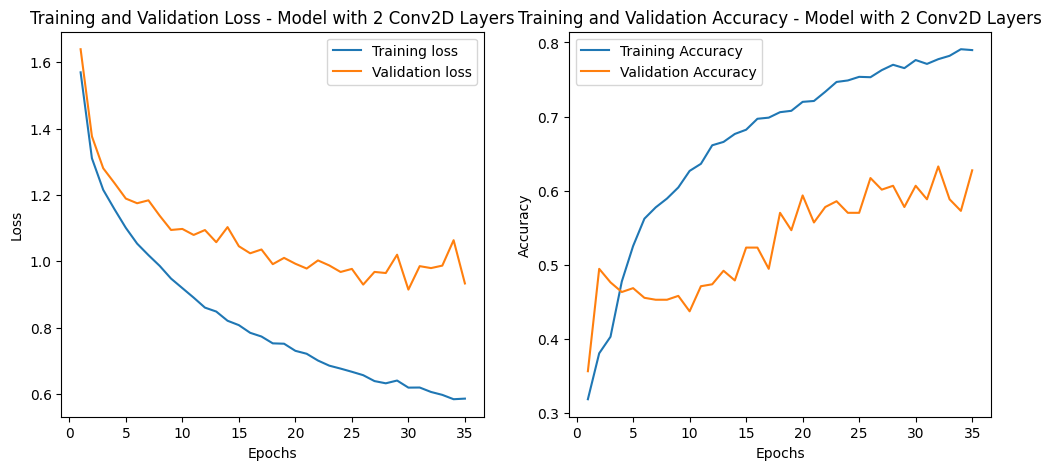

In [ ]:
plot_training_history(history_two, model_name='Model with 2 Conv2D Layers')

Hyperparameter tuning using 4 convolutional layers

In [ ]:
def build_model_four():
  model = models.Sequential() # initialize

  # FIRST CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (img_height, img_width, 1)))
  # max pooling layer to reduce spatial dimensions
  model.add(layers.MaxPooling2D((2,2)))

  # SECOND CONVOVLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # THIRD CONVOVLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # FOURTH CONVOVLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # FULLY CONNECTED LAYERS:
  # Flatten into a 1D vector
  model.add(layers.Flatten())
  # Dense fully connected layer, projects the flattened features into a 10D space
  model.add(layers.Dense(10, activation = 'relu'))
  # Final dense layer, with 6 units (one per class)
  model.add(layers.Dense(6, activation = 'softmax')) # softmax converts logits into probabilities, for multi-class classification

  # MODEL COMPILATION:
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model_four = build_model_four()
model_four.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 5, 12, 8)            │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 2, 6, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             970 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,868 (11.20 KB)

 Trainable params: 2,868 (11.20 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_four = model_four.fit(train_data_subsampled, validation_data = val_data_subsampled, epochs = 35, verbose = 1, callbacks = [early_stopping])

Epoch 1/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 36s 180ms/step - accuracy: 0.2078 - loss: 1.7871 - val_accuracy: 0.4661 - val_loss: 1.6276
Epoch 2/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.3761 - loss: 1.4517 - val_accuracy: 0.4036 - val_loss: 1.3482
Epoch 3/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 171ms/step - accuracy: 0.4890 - loss: 1.1737 - val_accuracy: 0.3854 - val_loss: 1.3038
Epoch 4/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.5380 - loss: 1.0941 - val_accuracy: 0.5234 - val_loss: 1.1265
Epoch 5/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 172ms/step - accuracy: 0.5769 - loss: 1.0241 - val_accuracy: 0.4870 - val_loss: 1.1795
Epoch 6/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 181ms/step - accuracy: 0.5996 - loss: 0.9637 - val_accuracy: 0.5625 - val_loss: 1.0356
Epoch 7/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step - accuracy: 0.6282 - loss: 0.9094 - val_accuracy: 0.4974 - val_loss: 1.1862
Epoch 8/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.6318 - loss: 0

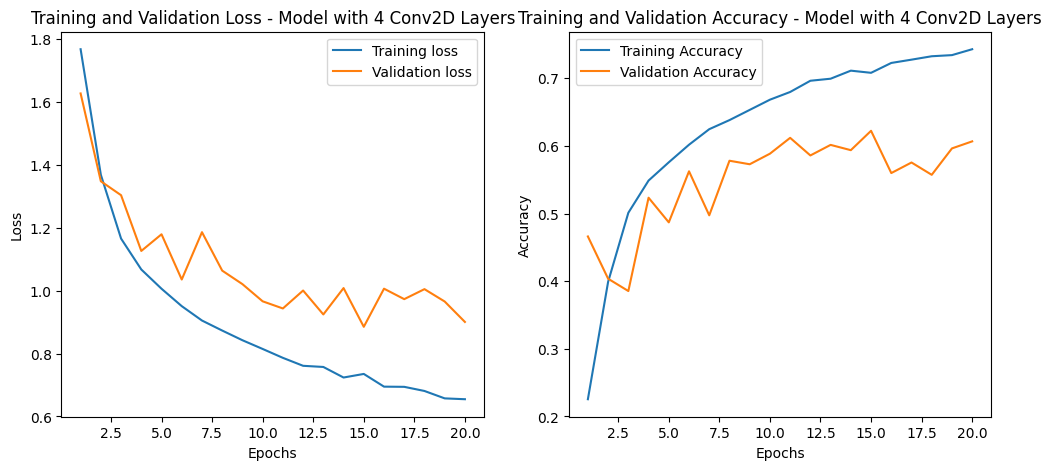

In [ ]:
plot_training_history(history_four, model_name='Model with 4 Conv2D Layers')

In [ ]:
history_four_unbalanced = model_four.fit(train_data, validation_data = val_data_subsampled, epochs = 35, verbose = 0, callbacks = [early_stopping])

In [ ]:
plot_training_history(history_four_unbalanced, model_name='Model with 4 Conv2D Layers on unbalanced data')

Hyperparameter tuning using 5 convolutional layers

In [ ]:
def build_model_five():
  model = models.Sequential() # initialize

  # FIRST CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (img_height, img_width, 1)))
  # max pooling layer to reduce spatial dimensions
  model.add(layers.MaxPooling2D((2,2)))

  # SECOND CONVOVLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # THIRD CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # FOURTH CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((1,1))) #Changed to 1,1 to avoid negative input dimensions

  # FIFTH CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D((1,1)))  #Changed to 1,1 to avoid negative input dimensions

  # FULLY CONNECTED LAYERS:
  # Flatten into a 1D vector
  model.add(layers.Flatten())
  # Dense fully connected layer, projects the flattened features into a 10D space
  model.add(layers.Dense(10, activation = 'relu'))
  # Final dense layer, with 6 units (one per class)
  model.add(layers.Dense(6, activation = 'softmax')) # softmax converts logits into probabilities, for multi-class classification

  # MODEL COMPILATION:
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model_five = build_model_five()
model_five.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 5, 12, 8)            │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 5, 12, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 3, 10, 8)            │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 3, 10, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 240)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │           2,410 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,892 (19.11 KB)

 Trainable params: 4,892 (19.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_five = model_five.fit(train_data_subsampled, validation_data = val_data_subsampled, epochs = 35, verbose = 1, callbacks = [early_stopping])

Epoch 1/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 36s 178ms/step - accuracy: 0.2084 - loss: 1.7525 - val_accuracy: 0.2760 - val_loss: 1.5671
Epoch 2/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 180ms/step - accuracy: 0.3855 - loss: 1.3477 - val_accuracy: 0.3021 - val_loss: 1.4518
Epoch 3/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.4615 - loss: 1.2047 - val_accuracy: 0.5234 - val_loss: 1.2036
Epoch 4/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.5058 - loss: 1.1170 - val_accuracy: 0.4896 - val_loss: 1.1586
Epoch 5/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 33s 178ms/step - accuracy: 0.5426 - loss: 1.0528 - val_accuracy: 0.4714 - val_loss: 1.2844
Epoch 6/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 180ms/step - accuracy: 0.5875 - loss: 0.9561 - val_accuracy: 0.5547 - val_loss: 1.1648
Epoch 7/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 32s 173ms/step - accuracy: 0.6117 - loss: 0.9129 - val_accuracy: 0.5286 - val_loss: 1.1813
Epoch 8/35
187/187 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.6282 - loss: 0

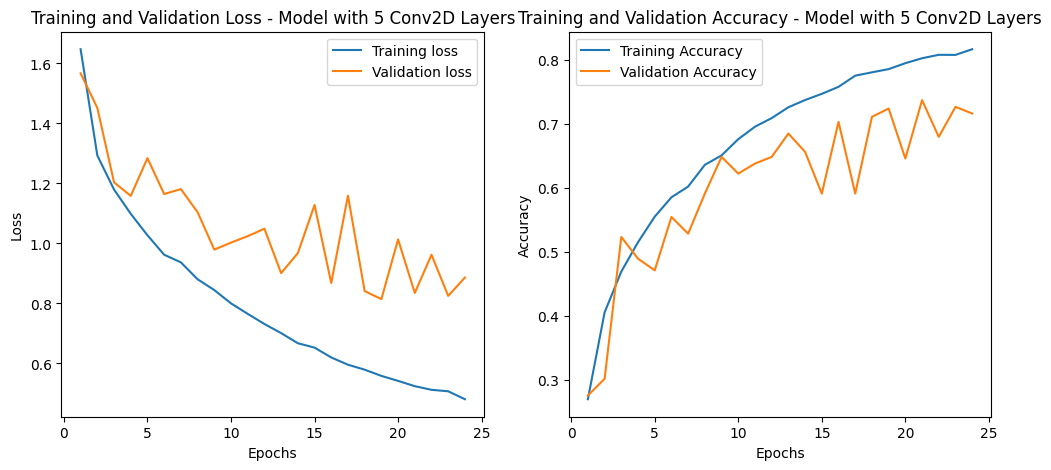

In [ ]:
plot_training_history(history_five, model_name='Model with 5 Conv2D Layers')

## IV) Filter size and Number Adjustments

In [ ]:
from keras import models, layers, Input

def build_model(filters_per_block=8):
  model = models.Sequential() # initialize

  # FIRST CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(filters_per_block, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
  model.add(layers.MaxPooling2D((2,2)))

  # SECOND CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(filters_per_block, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # THIRD CONVOLUTIONAL BLOCK:
  model.add(layers.Conv2D(filters_per_block, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))

  # FULLY CONNECTED LAYERS:
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(6, activation='softmax'))

  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

# Experiment with different filter sizes
filter_sizes = [8, 16, 32, 64]  # you can add more filter sizes to this list
results = {}

for filters in filter_sizes:
    print(f'Training with {filters} filters...')
    model = build_model(filters_per_block=filters)
    history = model.fit(train_data_balanced, validation_data = val_data, epochs = 10, verbose = 1)

    # Save the accuracy for each filter size
    results[filters] = history.history['val_accuracy'][-1]

# Output the results
for filters, accuracy in results.items():
    print(f'Filters: {filters}, Validation Accuracy: {accuracy:.4f}')


Training with 8 filters...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.2708 - loss: 1.6294 - val_accuracy: 0.1639 - val_loss: 1.5255
Epoch 2/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.3764 - loss: 1.3394 - val_accuracy: 0.2914 - val_loss: 1.4588
Epoch 3/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.4381 - loss: 1.2121 - val_accuracy: 0.5473 - val_loss: 1.1921
Epoch 4/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.5531 - loss: 1.0368 - val_accuracy: 0.5224 - val_loss: 1.1430
Epoch 5/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - accuracy: 0.6451 - loss: 0.8932 - val_accuracy: 0.6483 - val_loss: 0.9238
Epoch 6/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.6849 - loss: 0.8158 - val_accuracy: 0.6467 - val_loss: 0.9293
Epoch 7/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.7131 - loss: 0.7492 - val_accuracy: 0.6655 - val_loss: 0.8893
Epoch 8/10
932/932 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.7273 - loss: 0.7161 - 

## V & VI) Optimizer, Learning Rate, and Dropout Tuning

In [ ]:
# Hyperparameter grid

import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW, SGD, RMSprop
from tensorflow.keras.layers import Dropout

# Define hyperparameter options
optimizers = {
    "Adam" : Adam,
    "AdamW": AdamW
}
learning_rates = [0.001]
dropout_rates = [0.2, 0.5]

# Generate all hyperparameter combinations
hyperparameter_combinations = list(itertools.product(optimizers.keys(), learning_rates, dropout_rates))

# Subsample training data (20%)
sample_frac = 0.2
df_train_subsampled = df_train_balanced.sample(frac=sample_frac, random_state=42)

# Create new data generator with subsampled data
train_data_subsampled = data_gen.flow_from_dataframe(
    df_train_subsampled, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

# Store results
results = {}
num_trials = 1  # Run each combination twice


Found 5963 validated image filenames belonging to 6 classes.


In [ ]:
# train model with hyperparameters

def build_tuned_model(optimizer, learning_rate, dropout_rate):
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(8, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(8, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(Dropout(dropout_rate))  # Apply dropout
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    opt = optimizers[optimizer](learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

for optimizer, learning_rate, dropout_rate in hyperparameter_combinations:
    for trial in range(num_trials):
        print(f"\n🚀 Training: Optimizer={optimizer}, LR={learning_rate}, Dropout={dropout_rate}, Trial={trial+1}\n")

        model = build_tuned_model(optimizer, learning_rate, dropout_rate)

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        history = model.fit(train_data_subsampled, validation_data=val_data, epochs=5, verbose=1, callbacks=[early_stopping])

        best_train_acc = max(history.history['accuracy'])
        best_val_acc = max(history.history['val_accuracy'])

        key = f"{optimizer}_lr{learning_rate}_dropout{dropout_rate}_trial{trial+1}"
        results[key] = {
            "optimizer": optimizer,
            "learning_rate": learning_rate,
            "dropout_rate": dropout_rate,
            "best_train_accuracy": best_train_acc,
            "best_val_accuracy": best_val_acc,
            "epochs_trained": len(history.history['val_loss'])
        }



🚀 Training: Optimizer=Adam, LR=0.001, Dropout=0.2, Trial=1



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.2350 - loss: 1.7278 - val_accuracy: 0.5219 - val_loss: 1.2249
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.4899 - loss: 1.2271 - val_accuracy: 0.6176 - val_loss: 0.9732
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 215ms/step - accuracy: 0.5863 - loss: 0.9773 - val_accuracy: 0.6504 - val_loss: 0.8701
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 209ms/step - accuracy: 0.6320 - loss: 0.8639 - val_accuracy: 0.6743 - val_loss: 0.8334
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - accuracy: 0.6897 - loss: 0.7743 - val_accuracy: 0.6868 - val_loss: 0.8629

🚀 Training: Optimizer=Adam, LR=0.001, Dropout=0.5, Trial=1

Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 234ms/step - accuracy: 0.2155 - loss: 1.7511 - val_accuracy: 0.4636 - val_loss: 1.3452
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 208ms/step - accuracy: 0.4385 - loss: 1.2948 - val_accuracy: 0.5302 - val_loss: 1.1588
Epoch 3/5
187/187 ━━━━━━━━━━━

In [ ]:
# Report final results
print("\n🚀 Summary of Results:")
for key, value in results.items():
    print(f"{key}: {value}")

# analyse models

# Sort by best validation accuracy (ensuring best generalization)
sorted_results = sorted(results.items(), key=lambda x: x[1]['best_val_accuracy'], reverse=True)

# Select top 3 combinations for deeper analysis
top_3_combinations = sorted_results[:3]




🚀 Summary of Results:
Adam_lr0.001_dropout0.2_trial1: {'optimizer': 'Adam', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'best_train_accuracy': 0.6790206432342529, 'best_val_accuracy': 0.6867846250534058, 'epochs_trained': 5}
Adam_lr0.001_dropout0.5_trial1: {'optimizer': 'Adam', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'best_train_accuracy': 0.5829280614852905, 'best_val_accuracy': 0.5894901156425476, 'epochs_trained': 5}
AdamW_lr0.001_dropout0.2_trial1: {'optimizer': 'AdamW', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'best_train_accuracy': 0.6218346357345581, 'best_val_accuracy': 0.6566076874732971, 'epochs_trained': 5}
AdamW_lr0.001_dropout0.5_trial1: {'optimizer': 'AdamW', 'learning_rate': 0.001, 'dropout_rate': 0.5, 'best_train_accuracy': 0.5436860918998718, 'best_val_accuracy': 0.6222684979438782, 'epochs_trained': 5}


## VIII) Modifying Dense Layers

First we tried adding an additional dense layer, however this significantly decreased the models training and validation accuracy and created a high level of overfitting. Therefore we decided to use only two dense layers and improve feature classification through experimenting with additional neurons.


Creating a model with 3 dense layers

In [ ]:
def build_model():
  model_d = models.Sequential() # initialize

  # FIRST CONVOLUTIONAL BLOCK:
  # 2d convolutional layer, 8 filters, input_shape appropriate for grey-scale images
  model_d.add(layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (img_height, img_width, 1)))
  # max pooling layer to reduce spatial dimensions
  model_d.add(layers.MaxPooling2D((2,2)))

  # SECOND CONVOVLUTIONAL BLOCK:
  # Same specifications and another max pooling
  model_d.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model_d.add(layers.MaxPooling2D((2,2)))

  # THIRD CONVOVLUTIONAL BLOCK:
  # Same specifications and another max pooling
  model_d.add(layers.Conv2D(8, (3,3), activation = 'relu'))
  model_d.add(layers.MaxPooling2D((2,2)))

  # FULLY CONNECTED LAYERS:
  # Flatten into a 1D vector
  model_d.add(layers.Flatten())
  # Dense fully connected layer, projects the flattened features into a 10D space
  model_d.add(layers.Dense(10, activation = 'relu'))
  #additional dense layer
  model_d.add(layers.Dense(10, activation = 'relu'))
  # Final dense layer, with 6 units (one per class)
  model_d.add(layers.Dense(6, activation = 'softmax')) # softmax converts logits into probabilities, for multi-class classification

  # MODEL COMPILATION:
  # categorical cross entropy is appropriate for multi-class classification
  model_d.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model_d

model_d = build_model()
model_d.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 5, 12, 8)            │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 2, 6, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             970 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,978 (11.63 KB)

 Trainable params: 2,978 (11.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_d = model_d.fit(train_data_subsampled, validation_data = val_data_subsampled, epochs = 10, verbose = 1)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.1849 - loss: 1.7864 - val_accuracy: 0.2214 - val_loss: 1.6906
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.3300 - loss: 1.4585 - val_accuracy: 0.1901 - val_loss: 1.4638
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.4295 - loss: 1.2544 - val_accuracy: 0.3854 - val_loss: 1.2997
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.4822 - loss: 1.1755 - val_accuracy: 0.4062 - val_loss: 1.2184
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5030 - loss: 1.1211 - val_accuracy: 0.3620 - val_loss: 1.2624
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.5396 - loss: 1.0554 - val_accuracy: 0.3906 - val_loss: 1.1899
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5415 - loss: 1.0339 - val_accuracy: 0.3464 - val_loss: 1.2716
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.5470 - loss: 0.9999 - 

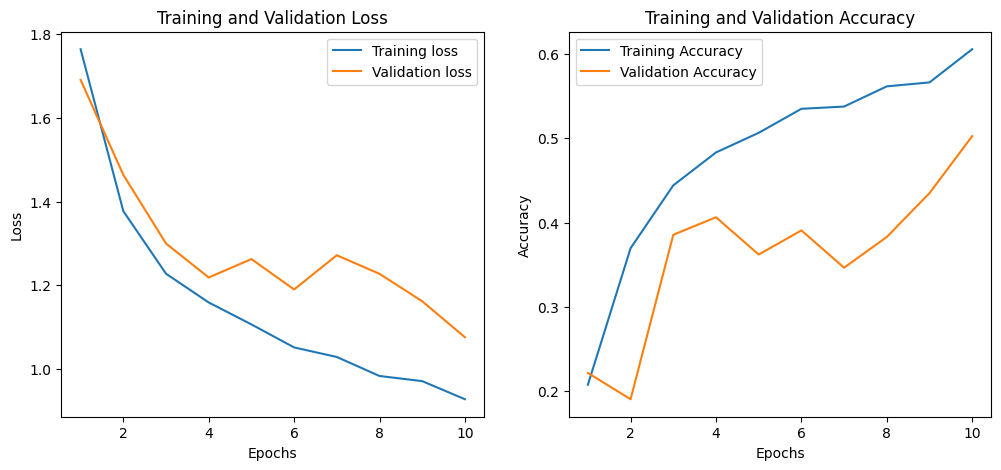

In [ ]:
plot_training_history(history_d, model_name='Model with 3 Dense Layers')


Training model with 10 and 6 neurons in dense layers...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


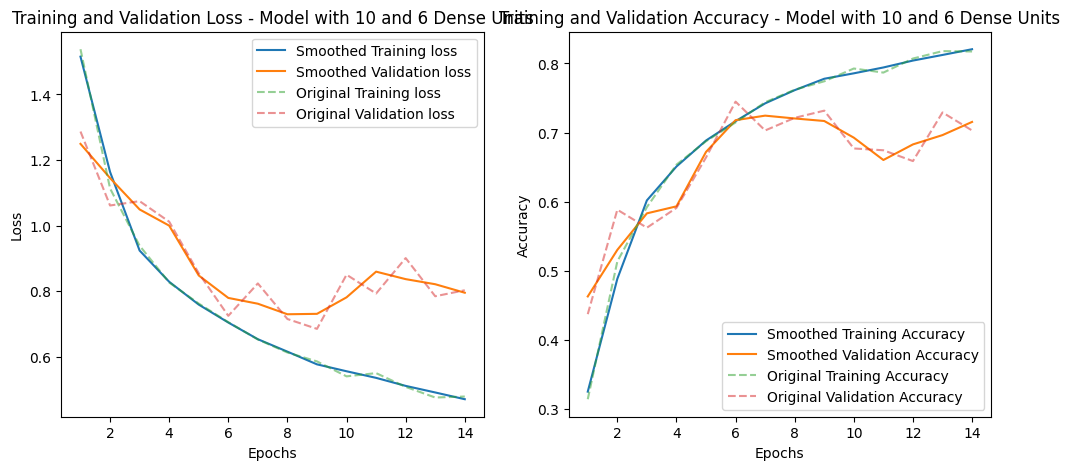


Training model with 32 and 6 neurons in dense layers...


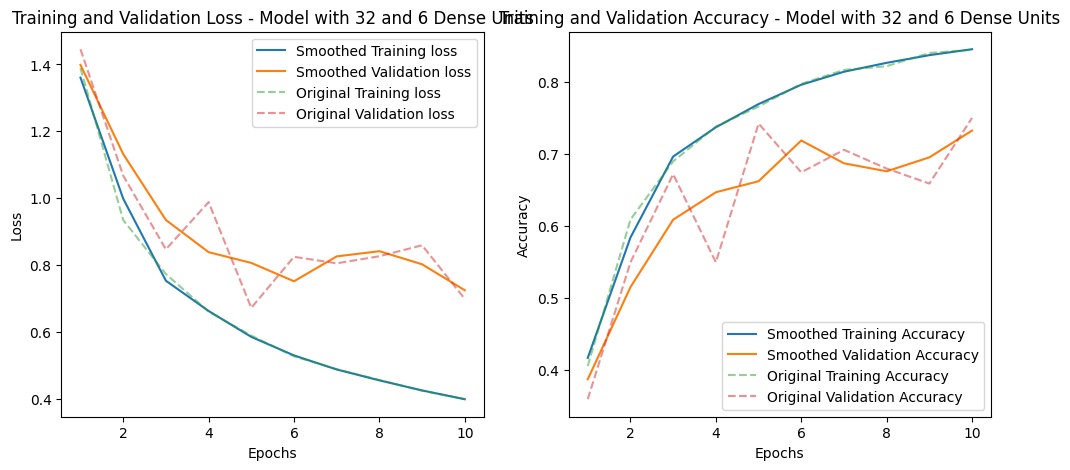


Training model with 64 and 6 neurons in dense layers...


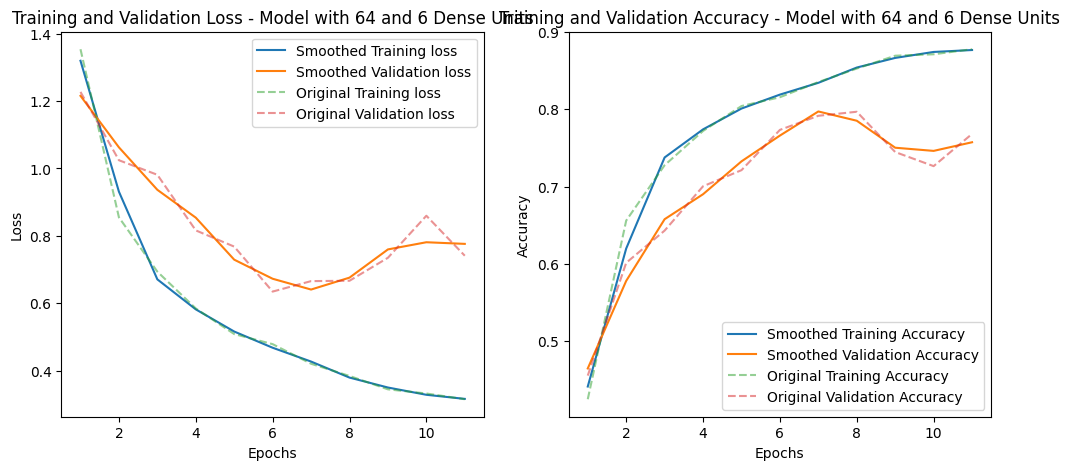


Training model with 128 and 6 neurons in dense layers...


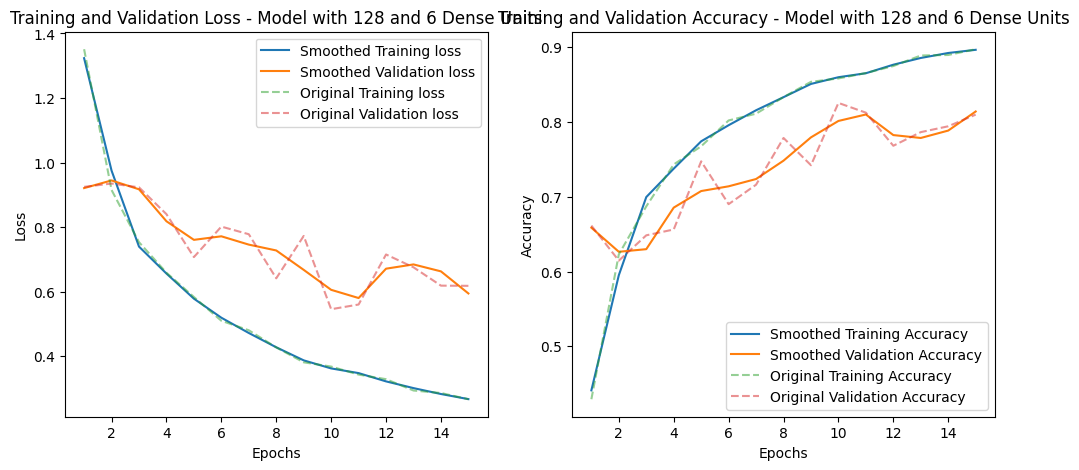


Training model with 256 and 6 neurons in dense layers...


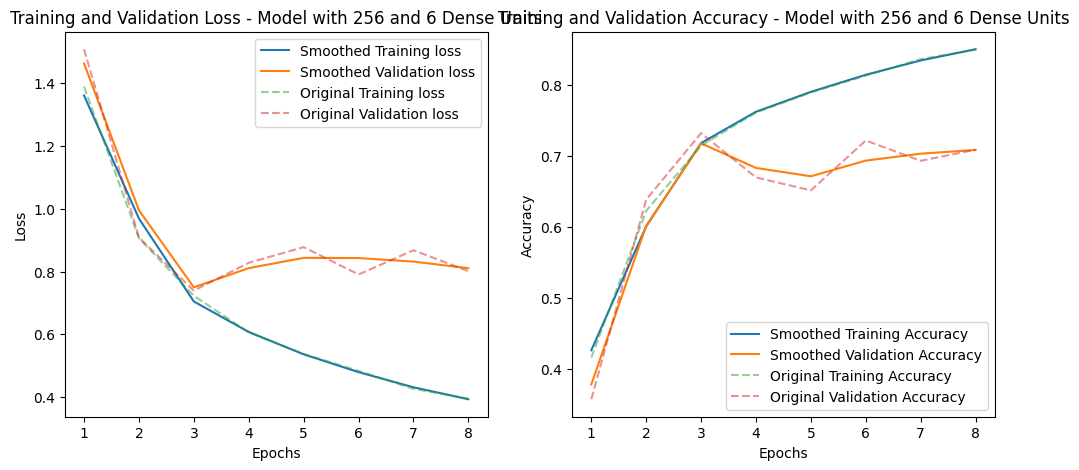

In [ ]:
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from tensorflow.keras.callbacks import EarlyStopping

# Assuming img_height, img_width, train_data_balanced, val_data, and batch_size are defined

def smooth_curve(data, smoothing_window=5, polyorder=2):
    """
    Smooths a curve using a Savitzky-Golay filter.

    Args:
        data (array-like): The data to smooth.
        smoothing_window (int): The window size for the filter.
        polyorder (int): The order of the polynomial used in the filter.

    Returns:
        array-like: The smoothed data.
    """
    if len(data) >= smoothing_window:
        return savgol_filter(data, smoothing_window, polyorder)
    else:
        return data

def plot_training_history(history, model_name, smoothing_window=5, polyorder=2):
    """
    Plots the training and validation loss and accuracy curves with smoothing.

    Args:
        history (History object): The history object returned by model.fit().
        model_name (str): The name of the model for the plot title.
        smoothing_window (int): The window size for the Savitzky-Golay filter.
        polyorder (int): The order of the polynomial used in the filter.
    """
    # Extracting data from the history object
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(train_loss) + 1)

    # Apply smoothing using the smooth_curve function
    train_loss_smooth = smooth_curve(train_loss, smoothing_window, polyorder)
    val_loss_smooth = smooth_curve(val_loss, smoothing_window, polyorder)
    train_acc_smooth = smooth_curve(train_acc, smoothing_window, polyorder)
    val_acc_smooth = smooth_curve(val_acc, smoothing_window, polyorder)


    # Plotting:
    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_smooth, label="Smoothed Training loss")
    plt.plot(epochs, val_loss_smooth, label="Smoothed Validation loss")
    plt.plot(epochs, train_loss, label="Original Training loss", linestyle='--', alpha=0.5)
    plt.plot(epochs, val_loss, label="Original Validation loss", linestyle='--', alpha=0.5)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and Validation Loss - {model_name}")

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_smooth, label="Smoothed Training Accuracy")
    plt.plot(epochs, val_acc_smooth, label="Smoothed Validation Accuracy")
    plt.plot(epochs, train_acc, label="Original Training Accuracy", linestyle='--', alpha=0.5)
    plt.plot(epochs, val_acc, label="Original Validation Accuracy", linestyle='--', alpha=0.5)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and Validation Accuracy - {model_name}")

    plt.show()

def build_model_with_dense_units(dense_units_1, dense_units_2):
    """
    Builds the CNN model with a specified number of neurons in the dense layers.

    Args:
        dense_units_1 (int): Number of neurons in the first dense layer.
        dense_units_2 (int): Number of neurons in the second dense layer.

    Returns:
        A compiled Keras model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3,3), activation = 'relu', input_shape = (img_height, img_width, 1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(8, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units_1, activation = 'relu'))
    model.add(layers.Dense(dense_units_2, activation = 'softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the different numbers of neurons to test
dense_units_options = [(32, 6), (64, 6), (128, 6), (256, 6)]


# Loop over the different numbers of neurons
for dense_units_1, dense_units_2 in dense_units_options:
    print(f"\nTraining model with {dense_units_1} and {dense_units_2} neurons in dense layers...")

    # Build the model with the current number of neurons
    model = build_model_with_dense_units(dense_units_1, dense_units_2)

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=5,  # Allow 5 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights

    # Train the model and store the history
    history = model.fit(train_data_subsampled, validation_data = val_data_subsampled, epochs = 20, verbose = 0, callbacks=[early_stopping])

    # Plot training history
    plot_training_history(history, model_name=f'Model with {dense_units_1} and {dense_units_2} Dense Units')


Training model with 64 and 6 neurons in dense layers...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


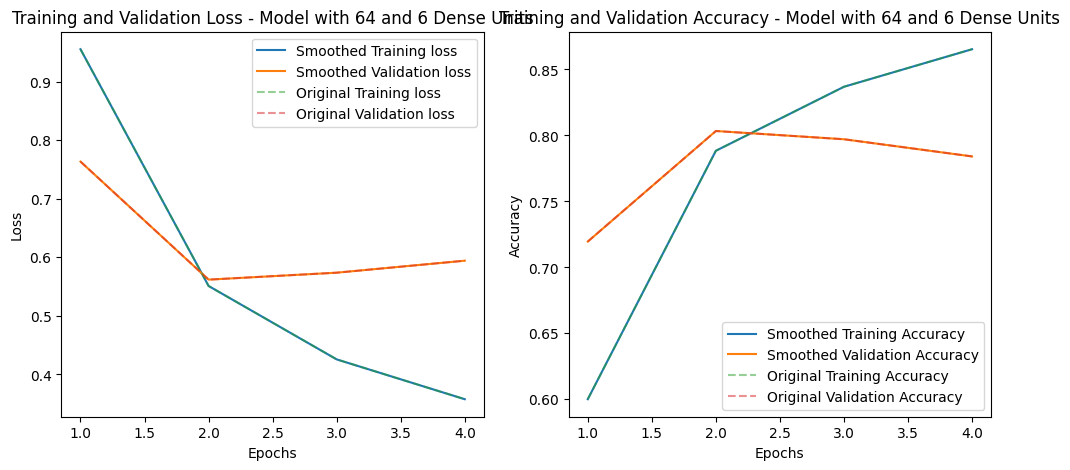


Training model with 128 and 6 neurons in dense layers...


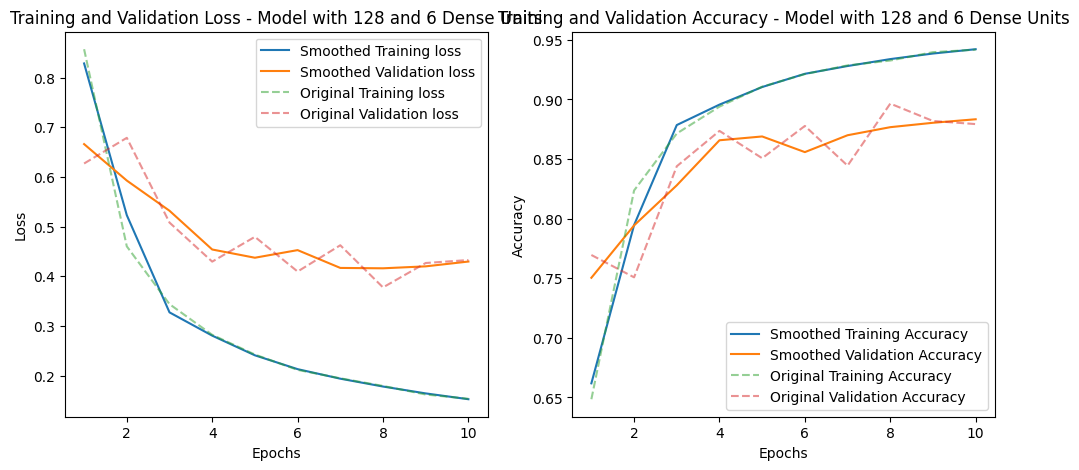

In [ ]:
# Define the different numbers of neurons to test
dense_units_options = [(64, 6), (128, 6)]

# Loop over the different numbers of neurons
for dense_units_1, dense_units_2 in dense_units_options:
    print(f"\nTraining model with {dense_units_1} and {dense_units_2} neurons in dense layers...")

    # Build the model with the current number of neurons
    model = build_model_with_dense_units(dense_units_1, dense_units_2)

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=2,  # Allow 2 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights

    # Train the model and store the history
    history_full = model.fit(train_data_balanced, validation_data = val_data, epochs = 20, verbose = 0, callbacks=[early_stopping])

    # Plot training history
    plot_training_history(history_full, model_name=f'Model with {dense_units_1} and {dense_units_2} Dense Units')

## VIII) Testing diffent activation functions

In [ ]:
from keras import models, layers
from keras.optimizers import Adam

# Function to build the model with different activation functions
def build_model(activation_function='relu'):
    model = models.Sequential()

    # FIRST CONVOLUTIONAL BLOCK:
    model.add(layers.Conv2D(16, (3, 3), activation=activation_function, input_shape = (img_height, img_width, 1)))
    model.add(layers.MaxPooling2D((2, 2)))

    # SECOND CONVOLUTIONAL BLOCK:
    model.add(layers.Conv2D(16, (3, 3), activation=activation_function))
    model.add(layers.MaxPooling2D((2, 2)))

    # THIRD CONVOLUTIONAL BLOCK:
    model.add(layers.Conv2D(16, (3, 3), activation=activation_function))
    model.add(layers.MaxPooling2D((2, 2)))

    # FULLY CONNECTED LAYERS:
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation_function))  # Can change activation here as well
    model.add(layers.Dense(6, activation='softmax'))  # Softmax for multi-class classification

    # Compile the model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Define activation functions to test
activation_functions = ['sigmoid', 'tanh', 'elu', 'swish']

# Store results for each activation function
results = {}

# Test each activation function
for activation in activation_functions:
    print(f"Training with {activation} activation...")
    model = build_model(activation_function=activation)
    history_act = model.fit(train_data_subsampled, validation_data=val_data_subsampled, epochs=5, verbose=1)

    # Save the final validation accuracy for each activation function
    results[activation] = history_act.history['val_accuracy'][-1]

# Print results
for activation, accuracy in results.items():
    print(f"Activation: {activation}, Validation Accuracy: {accuracy:.4f}")


Training with sigmoid activation...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 247ms/step - accuracy: 0.1679 - loss: 1.8472 - val_accuracy: 0.1328 - val_loss: 1.8304
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 243ms/step - accuracy: 0.1626 - loss: 1.7971 - val_accuracy: 0.0182 - val_loss: 1.8447
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 279ms/step - accuracy: 0.1652 - loss: 1.7982 - val_accuracy: 0.0469 - val_loss: 1.8212
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 76s 249ms/step - accuracy: 0.1885 - loss: 1.7952 - val_accuracy: 0.1328 - val_loss: 1.8305
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.1677 - loss: 1.7957 - val_accuracy: 0.3021 - val_loss: 1.7601
Training with tanh activation...
Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 48s 245ms/step - accuracy: 0.3786 - loss: 1.4650 - val_accuracy: 0.5938 - val_loss: 1.0318
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 52s 277ms/step - accuracy: 0.6687 - loss: 0.8323 - val_accuracy: 0.6667 - val_loss: 0.8237
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - a

# Best Model Performance So Far

The results of the hyperparameter tuning so far have given us a range of the best-performing hyperparameters. For example, we have decided that four convolutional layers performs better than three, that AdamW is the best optimizer, and that patience for early stopping should be set to 5. However, other parameters such as the filter sizes in the dense layers and learning rate had multiple settings that provided optimal results. In this stage we are testing which of those parameters works best when combined with all the other best-performing parameter settings.

The following parameters will be set:
*   Conv2D layers: 4 (each with 16 filters)
*   activation_function = 'swish'
*   optimizer_type = 'AdamW'
*   use_batchnorm = True
*   dropout_rate = 0.3

The following parameters will be tested:
*   dense_units_1 = [64, 128]
*   dense_units_2 = 6 (stays the same)
*   learning_rate = [0.001, 0,0001]
*   Training data = [ 'train_data',  'train_data_balanced' ]

Defining the plotting functions to use during testing

In [ ]:
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
import tensorflow as tf

def smooth_curve(data, smoothing_window=5, polyorder=2):
    """
    Smooths a curve using a Savitzky-Golay filter.

    Args:
        data (array-like): The data to smooth.
        smoothing_window (int): The window size for the filter.
        polyorder (int): The order of the polynomial used in the filter.

    Returns:
        array-like: The smoothed data.
    """
    if len(data) >= smoothing_window:
        return savgol_filter(data, smoothing_window, polyorder)
    else:
        return data

def plot_training_history(history, model_name, smoothing_window=5, polyorder=2):
    """
    Plots the training and validation loss and accuracy curves with smoothing.

    Args:
        history (History object): The history object returned by model.fit().
        model_name (str): The name of the model for the plot title.
        smoothing_window (int): The window size for the Savitzky-Golay filter.
        polyorder (int): The order of the polynomial used in the filter.
    """
    # Extracting data from the history object
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(train_loss) + 1)

    # Apply smoothing using the smooth_curve function
    train_loss_smooth = smooth_curve(train_loss, smoothing_window, polyorder)
    val_loss_smooth = smooth_curve(val_loss, smoothing_window, polyorder)
    train_acc_smooth = smooth_curve(train_acc, smoothing_window, polyorder)
    val_acc_smooth = smooth_curve(val_acc, smoothing_window, polyorder)


    # Plotting:
    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_smooth, label="Smoothed Training loss")
    plt.plot(epochs, val_loss_smooth, label="Smoothed Validation loss")
    plt.plot(epochs, train_loss, label="Original Training loss", linestyle='--', alpha=0.5)
    plt.plot(epochs, val_loss, label="Original Validation loss", linestyle='--', alpha=0.5)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Training and Validation Loss - {model_name}")

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_smooth, label="Smoothed Training Accuracy")
    plt.plot(epochs, val_acc_smooth, label="Smoothed Validation Accuracy")
    plt.plot(epochs, train_acc, label="Original Training Accuracy", linestyle='--', alpha=0.5)
    plt.plot(epochs, val_acc, label="Original Validation Accuracy", linestyle='--', alpha=0.5)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title(f"Training and Validation Accuracy - {model_name}")

    plt.show()

Defining a function that allows us to test combinations of some of the best performing hyperparameters

In [ ]:
def build_model_with_dense_units(dense_units_1, dense_units_2, learning_rate=0.001, activation='relu', use_batchnorm=False, dropout_rate=0.0, optimizer_type='Adam'):
    """
    Builds the CNN model with a specified number of neurons in the dense layers,
    a specified learning rate for the Adam optimizer, and a specified activation function.

    Args:
        dense_units_1 (int): Number of neurons in the first dense layer.
        dense_units_2 (int): Number of neurons in the second dense layer.
        learning_rate (float): Learning rate for the Adam optimizer.
        activation (str): Activation function to use in the convolutional and first dense layers.
        use_batchnorm (bool): If True, batch normalization layers are added.
        dropout_rate (float): Dropout rate to use. Set to 0 to disable dropout.
        optimizer_type (str): Type of optimizer ('Adam', 'AdamW')

    Returns:
        A compiled Keras model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3,3), activation = activation, input_shape = (img_height, img_width, 1)))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(16, (3,3), activation = activation))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(16, (3,3), activation = activation))
    if use_batchnorm:
         model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(16, (3,3), activation = activation))
    if use_batchnorm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    if dropout_rate > 0:
      model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(dense_units_1, activation = activation))
    if dropout_rate > 0:
      model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(dense_units_2, activation = 'softmax'))

    # Use the Adam optimizer with the specified learning rate
    if optimizer_type == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)
    else:
        optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Testing a model with:
* dense_units_1 = 64
* dense_units_2 = 6
* learning_rate = 0.001
* Training data = 'train_data_balanced'

This model had okay performance but the following model with 128 and 6 neurons performed better


Training model with 64 and 6 neurons in dense layers with the full dataset...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3824 - loss: 1.5674

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


932/932 ━━━━━━━━━━━━━━━━━━━━ 96s 92ms/step - accuracy: 0.3825 - loss: 1.5670 - val_accuracy: 0.6629 - val_loss: 0.8470 - learning_rate: 0.0010
Epoch 2/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.6492 - loss: 0.8517 - val_accuracy: 0.7617 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 3/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - accuracy: 0.7318 - loss: 0.6652 - val_accuracy: 0.7867 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 4/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.7739 - loss: 0.5872 - val_accuracy: 0.7867 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 5/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.7967 - loss: 0.5301 - val_accuracy: 0.8241 - val_loss: 0.4610 - learning_rate: 0.0010
Epoch 6/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.8161 - loss: 0.4833 - val_accuracy: 0.8137 - val_loss: 0.4907 - learning_rate: 0.0010
Epoch 7/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 71s 76ms/step - accuracy: 0.8318 - loss: 0.4467

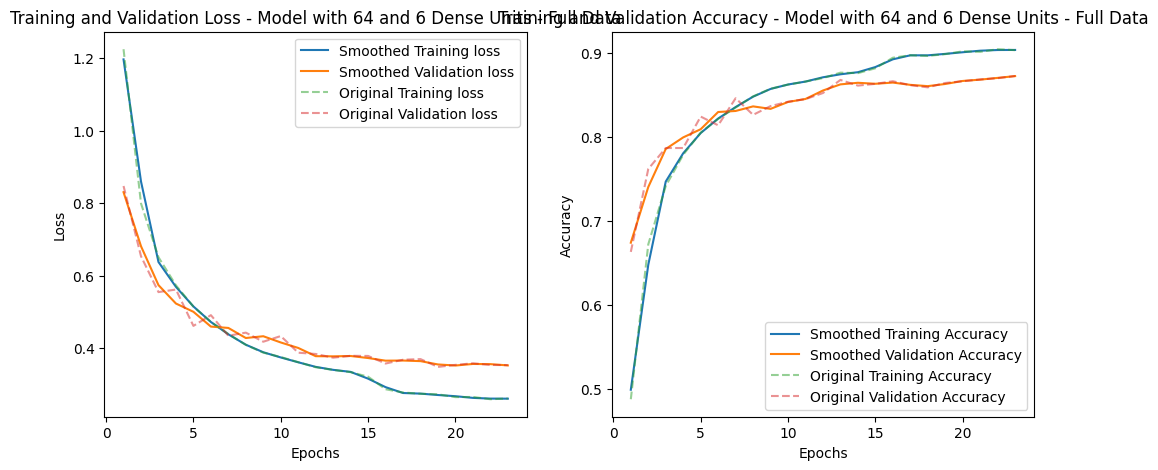

In [ ]:
# Define the number of neurons and learning rate to test
dense_units_1 = 64
dense_units_2 = 6
learning_rate = 0.001
activation_function = 'swish'
use_batchnorm = True # Add batch norm
dropout_rate = 0.2 # Add some dropout
optimizer_type = 'AdamW' # or 'Adam'


# Evaluate the model with the full dataset
print(f"\nTraining model with {dense_units_1} and {dense_units_2} neurons in dense layers with the full dataset...")
model_Lfull = build_model_with_dense_units(dense_units_1, dense_units_2, learning_rate=learning_rate, activation=activation_function, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer_type=optimizer_type)

# Define EarlyStopping callback
early_stopping_full = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=4,  # Allow 4 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights
reduce_lr_full = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

# Train the model and store the history
history_Lfull = model_Lfull.fit(train_data_balanced, validation_data = val_data, epochs = 30, verbose = 1, callbacks=[early_stopping_full, reduce_lr_full])

# Plot training history
plot_training_history(history_Lfull, model_name=f'Model with {dense_units_1} and {dense_units_2} Dense Units - Full Data')

Testing a model with:
* dense_units_1 = 128
* dense_units_2 = 6
* learning_rate = 0.001
* Training data = 'train_data_balanced'


Training model with 128 and 6 neurons in dense layers with the full dataset...
Epoch 1/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 80s 78ms/step - accuracy: 0.4582 - loss: 1.3114 - val_accuracy: 0.7560 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 2/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.7339 - loss: 0.6624 - val_accuracy: 0.7732 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 3/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.8056 - loss: 0.4998 - val_accuracy: 0.8559 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 4/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.8452 - loss: 0.4124 - val_accuracy: 0.8398 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 5/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 68s 73ms/step - accuracy: 0.8657 - loss: 0.3585 - val_accuracy: 0.8418 - val_loss: 0.3959 - learning_rate: 0.0010
Epoch 6/30
932/932 ━━━━━━━━━━━━━━━━━━━━ 67s 72ms/step - accuracy: 0.8770 - loss: 0.3200 - val_accuracy: 0.8606 - val_loss: 0.3995 - learning_rate: 0.0

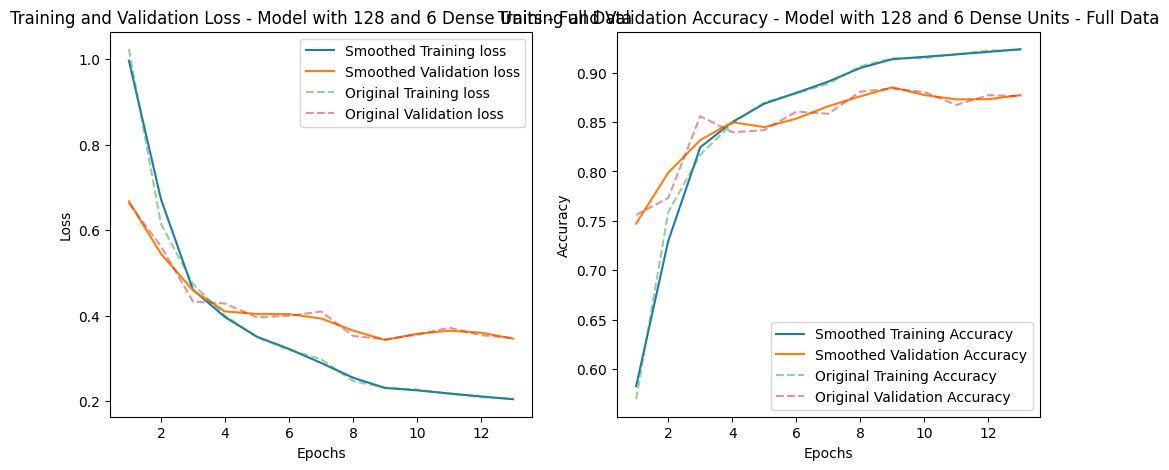

In [ ]:
# Define the number of neurons and learning rate to test
dense_units_1 = 128
dense_units_2 = 6
learning_rate = 0.001
activation_function = 'swish'
use_batchnorm = True # Add batch norm
dropout_rate = 0.2 # Add some dropout
optimizer_type = 'AdamW'


# Evaluate the model with the full dataset
print(f"\nTraining model with {dense_units_1} and {dense_units_2} neurons in dense layers with the full dataset...")
model_Hfull = build_model_with_dense_units(dense_units_1, dense_units_2, learning_rate=learning_rate, activation=activation_function, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer_type=optimizer_type)

# Define EarlyStopping callback
early_stopping_full = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=5,  # Allow 5 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights
reduce_lr_full = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

# Train the model and store the history
history_Hfull = model_Hfull.fit(train_data_balanced, validation_data = val_data, epochs = 30, verbose = 1, callbacks=[early_stopping_full, reduce_lr_full])

# Plot training history
plot_training_history(history_Hfull, model_name=f'Model with {dense_units_1} and {dense_units_2} Dense Units - Full Data')

The previous model with 128 and 6 neurons in the dense layers, has a higher accuracy but overfits more than the model with 64 and 6 neurons. To combat this we will use a smaller learning rate.

Testing a model with:
* dense_units_1 = 128
* dense_units_2 = 6
* learning_rate = 0.0001
* Training data = 'train_data_balanced'

In [ ]:
# Define the number of neurons and learning rate to test
dense_units_1 = 128
dense_units_2 = 6
learning_rate = 0.0001
activation_function = 'swish'
use_batchnorm = True # Add batch norm
dropout_rate = 0.2 # Add some dropout
optimizer_type = 'AdamW'


# Evaluate the model with the full dataset
print(f"\nTraining model with {dense_units_1} and {dense_units_2} neurons in dense layers with the full dataset...")
model_Hfull_Hlr = build_model_with_dense_units(dense_units_1, dense_units_2, learning_rate=learning_rate, activation=activation_function, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer_type=optimizer_type)

# Define EarlyStopping callback
early_stopping_full = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=4,  # Allow 4 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights
reduce_lr_full = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

# Train the model and store the history
history_Hfull_Hlr = model_Hlfull_Hlr.fit(train_data_balanced, validation_data = val_data, epochs = 30, verbose = 1, callbacks=[early_stopping_full, reduce_lr_full])

# Plot training history
plot_training_history(history_Hlfull_Hlr, model_name=f'Model with {dense_units_1} and {dense_units_2} Dense Units - Full Data')

In [ ]:
test_loss, test_accuracy = model_Hfull_Hlr.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

The model above overfit less and but had a poorer validation accuracy. As we know that oversampling data can lead to overfitting problems, we will try to test this model on the original unbalanced training data and keep the larger learning rate which resulting in a high validation accuracy.

Testing a model with:
* dense_units_1 = 128
* dense_units_2 = 6
* learning_rate = 0.001
* Training data = 'train_data'


Training model with 128 and 6 neurons in dense layers on the original non-oversampled data...
Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.4853 - loss: 1.4383 - val_accuracy: 0.3174 - val_loss: 2.0729 - learning_rate: 0.0010
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 31s 84ms/step - accuracy: 0.6942 - loss: 0.8096 - val_accuracy: 0.7690 - val_loss: 0.6336 - learning_rate: 0.0010
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7617 - loss: 0.6543 - val_accuracy: 0.7862 - val_loss: 0.6025 - learning_rate: 0.0010
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.7901 - loss: 0.5745 - val_accuracy: 0.8413 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.8198 - loss: 0.5257 - val_accuracy: 0.8335 - val_loss: 0.4893 - learning_rate: 0.0010
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.8268 - loss: 0.4751 - val_accuracy: 0.8543 - val_loss: 0.4454 - lea

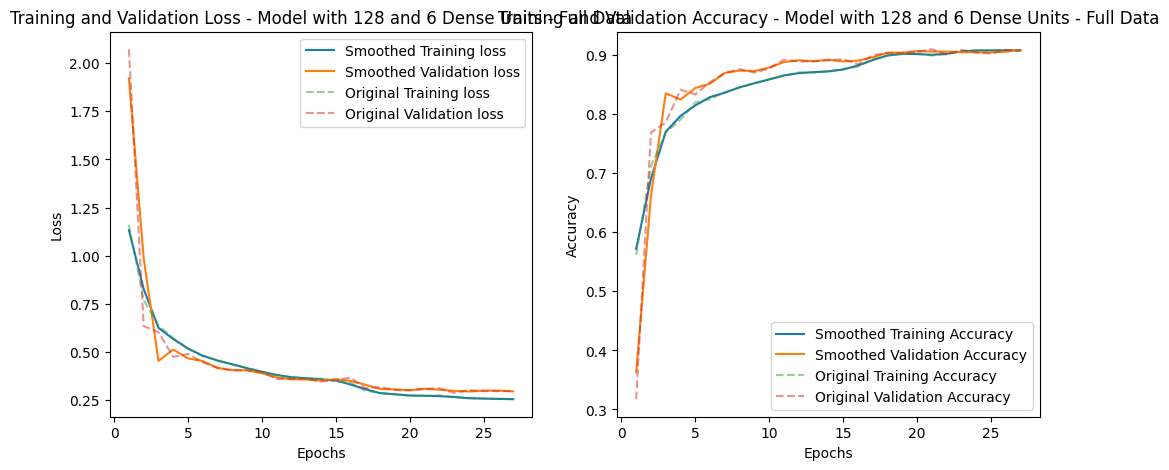

In [ ]:
# Define the number of neurons and learning rate to test
dense_units_1 = 128
dense_units_2 = 6
learning_rate = 0.001
activation_function = 'swish'
use_batchnorm = True # Add batch norm
dropout_rate = 0.2 # Add some dropout
optimizer_type = 'AdamW'


# Evaluate the model with the full dataset
print(f"\nTraining model with {dense_units_1} and {dense_units_2} neurons in dense layers on the original non-oversampled data...")
model_nonbal = build_model_with_dense_units(dense_units_1, dense_units_2, learning_rate=learning_rate, activation=activation_function, use_batchnorm=use_batchnorm, dropout_rate=dropout_rate, optimizer_type=optimizer_type)

# Define EarlyStopping callback
early_stopping_full = EarlyStopping(monitor='val_loss',  # Stop when validation loss stops improving
                               patience=5,  # Allow 5 epochs of no improvement before stopping
                               restore_best_weights=True)  # Revert to best weights
reduce_lr_full = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

# Train the model and store the history
history_nonbal = model_nonbal.fit(train_data, validation_data = val_data, epochs = 30, verbose = 1, callbacks=[early_stopping_full, reduce_lr_full])

# Plot training history
plot_training_history(history_nonbal, model_name=f'Model with {dense_units_1} and {dense_units_2} Dense Units - Full Data')

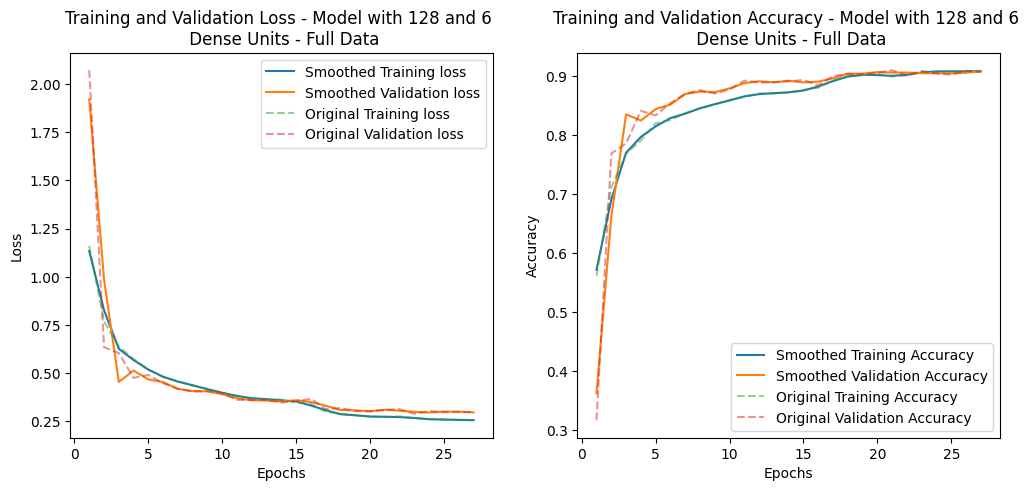

In [ ]:
# Plot training history
plot_training_history(history_nonbal, model_name=f'Model with {dense_units_1} and {dense_units_2} \n Dense Units - Full Data')

#### The Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score for the optimized model

61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


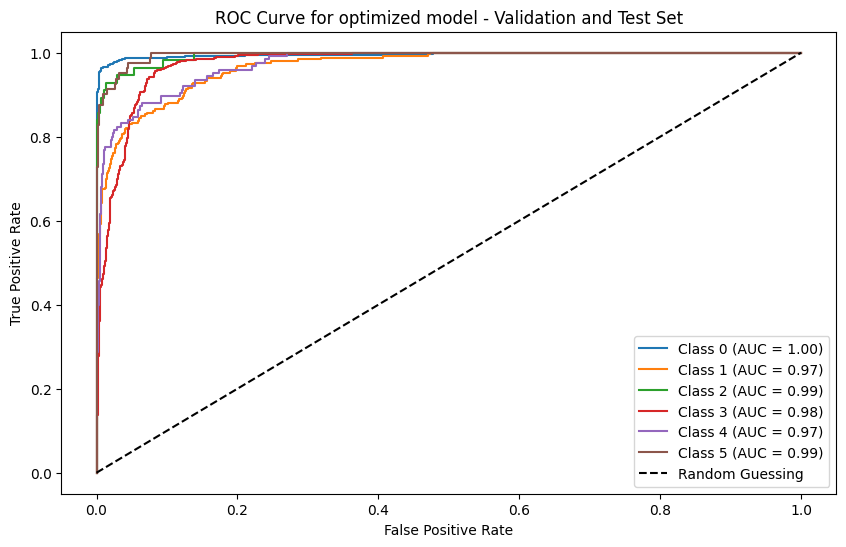

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Ensure labels are one-hot encoded
label_binarizer = LabelBinarizer().fit(df_train_encoded.iloc[:, 1:].columns)

# Convert labels to one-hot encoding format
y_val_onehot = label_binarizer.transform(df_val_encoded.iloc[:, 1:].idxmax(axis=1))
y_test_onehot = label_binarizer.transform(df_test_encoded.iloc[:, 1:].idxmax(axis=1))

# Get model predictions for model_nonbal
y_val_pred_nonbal = model_nonbal.predict(val_data)
y_test_pred_nonbal = model_nonbal.predict(test_data)

# Plot ROC Curve for model_nonbal
plt.figure(figsize=(10, 6))

for i in range(y_val_onehot.shape[1]):  # Loop through each class
    fpr, tpr, _ = roc_curve(y_val_onehot[:, i], y_val_pred_nonbal[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for optimized model - Validation and Test Set")
plt.legend()
plt.show()

#### Performance measures (accuracy, precision, recall, and F1-score) of the optimized model for both validation and test sets.

In [ ]:
from sklearn.metrics import classification_report

# Get predictions for model_nonbal on validation set
val_preds_nonbal = model_nonbal.predict(val_data)
val_preds_classes_nonbal = val_preds_nonbal.argmax(axis=1)  # Convert to class labels

# Get predictions for model_nonbal on test set
test_preds_nonbal = model_nonbal.predict(test_data)
test_preds_classes_nonbal = test_preds_nonbal.argmax(axis=1)

# Compute performance metrics for model_nonbal
print("Validation Performance for optimized model:")
print(classification_report(val_data.classes, val_preds_classes_nonbal))

print("\nTest Performance for optimized model:")
print(classification_report(test_data.classes, test_preds_classes_nonbal))

61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Validation Performance for optimized model:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       609
           1       0.84      0.75      0.79       252
           2       0.96      0.88      0.92        56
           3       0.89      0.95      0.92       799
           4       0.82      0.78      0.80       125
           5       0.95      0.78      0.86        81

    accuracy                           0.91      1922
   macro avg       0.91      0.85      0.88      1922
weighted avg       0.91      0.91      0.91      1922


Test Performance for optimized model:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       301
           1       0.88      0.76      0.82       152
           2       0.85      0.68      0.76        25
           3       0.87      0.93      0.90       412
           4       0.74

#### Conclusions

The conclusions of this section are that the model with the following parameters showed the best performance:
*   Conv2D layers: 4 (each with 16 filters)
*   dense_units_1 = 128
*   dense_units_2 = 6
*   learning_rate = 0.001
*   activation_function = 'swish'
*   use_batchnorm = True
*   dropout_rate = 0.2
*   optimizer_type = 'AdamW'
*   Training data = 'train_data' (*note this is the unbalanced/non-oversampled data)

This model has a test accuracy of 0.8985. Compared to the same model tested on oversampled data (test accuracy: 0.864) and the baseline model (test accuracy:0.7949)

Even though the model trained on the oversampled data has a similarly high accuracy, it overfits much more than when using the original unbalanced data.

# 6. Transfer Learning

#### I) Data Preparation for Transfer Learning

In [ ]:
# Convert grayscale images to RGB
tl_train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'  # Change from 'grayscale' to 'rgb'
)

tl_val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'  # Change from 'grayscale' to 'rgb'
)

tl_test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'  # Change from 'grayscale' to 'rgb'
)

Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


#### II) Model Setup and Training

In [ ]:
# Load the pre-trained DenseNet121 model without the top layers

base_densenet_model = DenseNet121(
    weights='imagenet',  # Use pre-trained ImageNet weights
    include_top=False,   # Remove fully connected layers
    input_shape=(img_height, img_width, 3)  # Converted to RGB (1->3 channels)
)

# freeze convolutional layers

for layer in base_densenet_model.layers:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from tensorflow.keras.optimizers import AdamW

# Custom Classifier

x = base_densenet_model.output # Retrieves the output feature map from the pretrained DenseNet121 model.
x = GlobalAveragePooling2D()(x) # converts feature map into a single vector by computing the average of each feature map across the sptial dimensions (height and width) = reduces dimensionality
x = Dense(128, activation='swish')(x) # Utilized the best perfoming hyperparameters from the tuned model
x = Dropout(0.2)(x) # reduces overfitting
predictions = Dense(6, activation='softmax')(x)



# building the full model
dense_model = Model(inputs= base_densenet_model.input, outputs=predictions)

# Model set-up for training
dense_model.compile(
    optimizer='AdamW', # automatically adjusts learning rate for each parameter
    loss='categorical_crossentropy', # multi-class classification - calculates how far predicted probabilities are from the true distribution (prob. provided by softmax)
    metrics=['accuracy'] #
    )

In [ ]:
history_DenseNet = dense_model.fit(
    tl_train_data,
    validation_data = tl_val_data,
    epochs = 30, # same as the tuned model
    verbose = 1
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 96s 188ms/step - accuracy: 0.5509 - loss: 1.3115 - val_accuracy: 0.7294 - val_loss: 0.7415
Epoch 2/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.7146 - loss: 0.7579 - val_accuracy: 0.7024 - val_loss: 0.7636
Epoch 3/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.7424 - loss: 0.6776 - val_accuracy: 0.7836 - val_loss: 0.6148
Epoch 4/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.7681 - loss: 0.6254 - val_accuracy: 0.7898 - val_loss: 0.5985
Epoch 5/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.7741 - loss: 0.6099 - val_accuracy: 0.7856 - val_loss: 0.5964
Epoch 6/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.7916 - loss: 0.5686 - val_accuracy: 0.8059 - val_loss: 0.5441
Epoch 7/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.7934 - loss: 0.5568 - val_accuracy: 0.8153 - val_loss: 0.5287
Epoch 8/30
374/374 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.7939 - loss: 0

#### III) Model Evaluation and Performance Visualization

In [ ]:
# Evaluate on the test set
y_pred_probs = dense_model.predict(tl_test_data)

tl_test_y_true_classes = tl_test_data.classes
tl_test_y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get model predictions
y_tl_val_pred = dense_model.predict(tl_val_data)
y_tl_test_pred = dense_model.predict(tl_test_data)

31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step


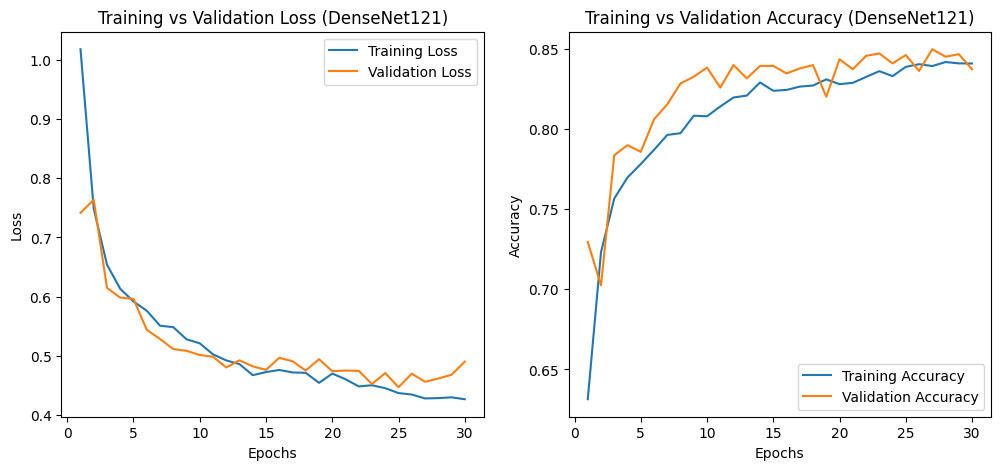

In [ ]:
# Extracting training history:

tl_train_loss = history_DenseNet.history["loss"]
tl_val_loss = history_DenseNet.history["val_loss"]
tl_train_acc = history_DenseNet.history["accuracy"]
tl_val_acc = history_DenseNet.history["val_accuracy"]
tl_epochs = range(1, len(tl_train_loss) + 1)

# Plot loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(tl_epochs, tl_train_loss, label="Training Loss")
plt.plot(tl_epochs, tl_val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss (DenseNet121)")

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(tl_epochs, tl_train_acc, label="Training Accuracy")
plt.plot(tl_epochs, tl_val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy (DenseNet121)")

plt.show()

In [ ]:
# Perfomance Measures:
from sklearn.metrics import classification_report

print("Test Performance:")
print(classification_report(tl_test_y_true_classes, tl_test_y_pred_classes))

Test Performance:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       301
           1       0.76      0.62      0.68       152
           2       0.69      0.72      0.71        25
           3       0.83      0.85      0.84       412
           4       0.70      0.61      0.65        69
           5       0.46      0.65      0.54        26

    accuracy                           0.82       985
   macro avg       0.72      0.73      0.72       985
weighted avg       0.82      0.82      0.82       985



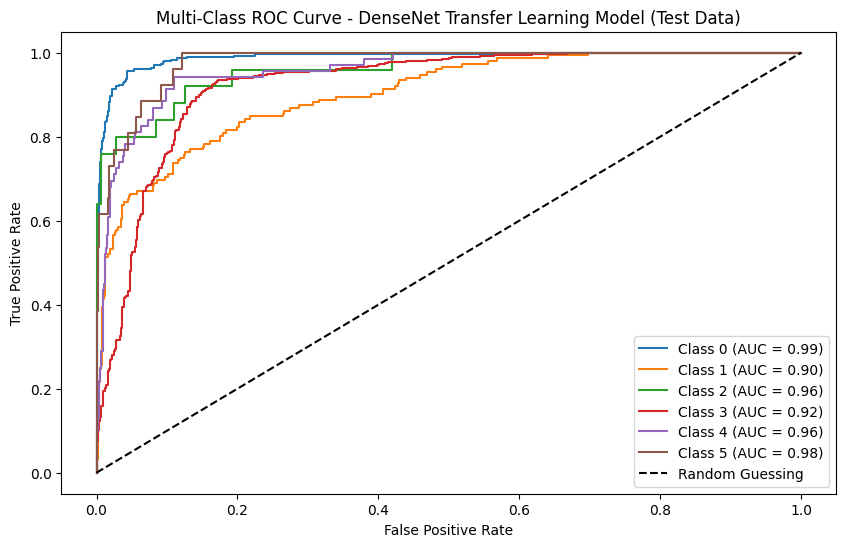

In [ ]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-Hot Encoding for true labels
y_true = tl_test_data.classes  # Integer class labels
y_true_one_hot = label_binarize(y_true, classes=range(6))  # Convert to one-hot

from sklearn.preprocessing import label_binarize

# Ensure test labels are one-hot encoded
y_true_one_hot = label_binarize(tl_test_data.classes, classes=range(6))  # One-hot encoding

plt.figure(figsize=(10, 6))

# Plot ROC curve for each class
for i in range(6):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

# Random guessing baseline
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve - DenseNet Transfer Learning Model (Test Data)")
plt.legend()
plt.show()



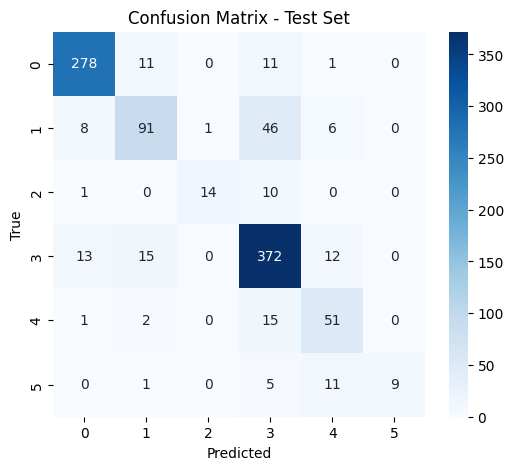

In [ ]:
# Confusion Matrix of DenseNet121 Model on Test Set

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
tl_test_cm = confusion_matrix(tl_test_y_true_classes,tl_test_y_pred_classes)

# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(tl_test_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")

plt.show()